# 0. Importación de librerias

In [91]:
# !pip install statsmodels
# !pip install stable-baselines3

In [92]:
# Librerías para el análisis de datos
import numpy as np  # Biblioteca para operaciones numéricas, especialmente útil para trabajar con matrices y arrays
import pandas as pd  # Biblioteca para manipulación y análisis de datos, especialmente para DataFrames
import statsmodels.api as sm  # Biblioteca para realizar modelos estadísticos, útil para regresiones y otros análisis estadísticos
from collections import Counter  # Contador de elementos en colecciones, útil para contar la frecuencia de elementos en una lista o array

# Librería para optimización
from gurobipy import Model, GRB, quicksum  # Gurobi es una biblioteca de optimización matemática. 
# Model permite definir el modelo de optimización,
# GRB contiene constantes (como tipos de variables y sentido de optimización),
# quicksum permite realizar sumas de forma rápida y eficiente en Gurobi.

# Librerías operacionales
import os  # Biblioteca para interactuar con el sistema operativo (ej. manejo de archivos y rutas)
from datetime import datetime  # Módulo para trabajar con fechas y tiempos, útil para capturar fechas actuales o manipular datos de tiempo
import matplotlib.pyplot as plt

# rl
# # Importar las librerías necesarias
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, BaseCallback
from stable_baselines3.common.monitor import Monitor
import gc
import logging  
from sklearn.preprocessing import normalize
from joblib import Parallel, delayed 
import warnings

import requests

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# <h2>1. Carga de datos desde excel a dataframes de pandas</h2>


In [93]:
def verificar_y_descargar(url, filename):
    """
    Verifica si el archivo existe localmente. Si no, lo descarga desde la URL proporcionada.
    """
    if not os.path.exists(filename):
        print(f"Descargando {filename} desde {url} ...")
        response = requests.get(url)
        with open(filename, "wb") as f:
            f.write(response.content)
        print(f"Archivo {filename} descargado exitosamente.")
    else:
        print(f"El archivo {filename} ya existe localmente.")

En primer lugar se cargan los datos iniciales desde los csv que nos proveen. (Esto puede tardar un ratito)

## <h3>1.1 Carga de 'Informacion_Clientes.csv'</h3>

En primer lugar se cargará la información de los clientes. Esto incluye las siguientes características de los clientes:

* **unnamed**: algo como uid
* **Rut**: identificador de Chile (supongo que por privacidad va desde 0 a max de observaciones)
* **Género**: Masculino o femenino
* **Categoría_Digital**: Si el cliente es digital o no
* **Elasticidad_Precios**: Baja, media o alta
* **Nacionalidad**: Chileno o extranjero
* **Propensión**: Número entre 0 y 1 que idica que tan propenso a cursar un credito es el cliente
* **Probabilidad_No_Pago**: Número entre 0 y 1 que indica la probabilidad de que el cliente no pague la deuda
* **Edad**: Numero entero de edad en años
* **Renta**: Renta promedio de los últimos 12 meses
* **Oferta_Consumo**: Monto máximo que puede cursar un cliente dado sus antecedentes crediticios y situación socioeconómica. 
* **Deuda_CMF**: Deuda que tiene el cliente en otros bancos. Efectivamente es deuda pendiente, pero de créditos otorgados por la competencia.
* **Tiempo_como_cliente**: Número de tiempo(no sé en que medida está) que el cliente lleva en el banco


In [94]:
file_id = '173bRZQG7NWfdpHJ-o4-NA3ieH1-Fhyok'
url_informacion_de_clientes = f'https://drive.google.com/uc?id={file_id}'
filename = "Informacion_Clientes.csv"

verificar_y_descargar(url_informacion_de_clientes, filename)
df_informacion_de_clientes = pd.read_csv(filename)

El archivo Informacion_Clientes.csv ya existe localmente.


Se elimina el tiempo como cliente ya que no aporta información

In [95]:
df_informacion_de_clientes.drop(columns=['Tiempo_como_cliente'], inplace=True)

## <h3>1.2 Carga de 'Simulaciones_Clientes.csv'</h3>



En segundo lugar se cargaran las simulaciones hechas por los clientes en la página del banco. Esto incluye las siguientes características de las simulaciones:
* **unnamed**: Supongo que es el número de simulacion registrada, un tipo de identificador de la simulación
* **fecha**: yyyy-mm-dd fecha de la simulación
* **rut**: identificador de Chile del cliente que hizo la simulacion
* **monto_simulado**: monto prestado al cliente
* **plazo_simulado**: plazo en **meses** del crédito
* **tasa_simulado**: costo para el cliente del credito

In [96]:
url_simulaciones_clientes = 'https://drive.usercontent.google.com/download?id=1IXyKwtKFLCUsAV1MtNqktiwKaHzV2D5A&authuser=0&confirm=t&uuid=edd22376-238f-4c1f-b603-728b07bafd7f&at=AENtkXaEURpV52p_BdWxyisvjhSQ%3A1730951026384'
filename = "Simulaciones_clientes.csv"
verificar_y_descargar(url_simulaciones_clientes, filename)

df_simulaciones_clientes = pd.read_csv(filename)

El archivo Simulaciones_clientes.csv ya existe localmente.


In [97]:
df_simulaciones_clientes = df_simulaciones_clientes[df_simulaciones_clientes['Monto_Simulado'] > 0]

## <h3>1.3 Carga de 'Tratamiento.csv'</h3>

En tercer lugar se cargara el tratamiento que ha tenido el banco con el cliente, es decir, cómo se han contactado con él. Esto incluye las siguientes características:

* **unnamed**: Número de tratamiento registrado
* **fecha**: yyyy-mm-dd
* **rut**: Identificador de Chile del cliente con el que se tiene el tipo de trato
* **n_correos**: Cantidad de correos que se enviaron en el mes que sale la fecha. Es decir, si sele fecha '2024-03-01', correspondería a los correos enviados en marzo de 2024.
* **asg_ejec**: Si el cliente tiene un ejecutivo asignado

In [98]:
url_tratamiento = 'https://drive.usercontent.google.com/download?id=1KTRwYGaWoQQnZwbk8VpdxKULMaOReoF5&authuser=0&confirm=t&uuid=4e4d7983-c5a5-412d-9f5b-b9bda1068b73&at=AENtkXZSxkDr84kWrDlz6ANq4ov2%3A1730951312566'
filename = "Tratamiento.csv"

verificar_y_descargar(url_tratamiento, filename)
df_tratamiento = pd.read_csv(filename)

El archivo Tratamiento.csv ya existe localmente.


## <h3>1.4 Carga de 'Ventas.csv'</h3>

Por último se cargaran las ventas que ha tenido el banco con el cliente. Esto incluye las siguientes características:

* **unnamed**: Índice sin significado
* **fecha**: yyyy-mm-dd -> fecha en la que se concretó la venta
* **rut**: identificador de Chile del cliente al que se le concretó la venta

In [99]:
file_id = '1Z4jMzZeD2q-4-ioSgyimppAdLZzqDkt3'
url_ventas = f'https://drive.google.com/uc?id={file_id}'
filename = "Ventas.csv"

verificar_y_descargar(url_ventas, filename)
df_ventas = pd.read_csv(filename)

El archivo Ventas.csv ya existe localmente.


## <h3>1.5 Filtrar data (fECHA) para que corra en el compu - omitir en la ejecucion final</h3>

In [100]:
Filtrar_data = True

Fecha_inicio = '2023-01-01'

if Filtrar_data:
    # df_simulaciones_clientes
    df_simulaciones_clientes['fecha'] = pd.to_datetime(df_simulaciones_clientes['fecha'])
    df_simulaciones_clientes = df_simulaciones_clientes[df_simulaciones_clientes['fecha'] >= Fecha_inicio]
    # df_tratamiento
    df_tratamiento['fecha'] = pd.to_datetime(df_tratamiento['fecha'])
    df_tratamiento = df_tratamiento[df_tratamiento['fecha'] >= Fecha_inicio]
    # df_ventas
    df_ventas['fecha'] = pd.to_datetime(df_ventas['fecha'])
    df_ventas = df_ventas[df_ventas['fecha'] >= Fecha_inicio]


# <h2>2. Joints de datos<h2>

In [101]:
# Unir los DataFrames 'df_informacion_de_clientes' y 'df_simulaciones_clientes' en base a la columna 'rut'
# El método 'how="left"' asegura que todos los registros de 'df_informacion_de_clientes' se conserven,
# incluso si no tienen coincidencia en 'df_simulaciones_clientes'.
df_simulaciones_e_informacion_de_clientes = pd.merge(
    df_informacion_de_clientes, 
    df_simulaciones_clientes, 
    on='rut', 
    how='left'
)

# Crear una nueva columna 'simulo' que indica si el cliente tiene un 'Monto_Simulado' o no
# El método 'notna()' devuelve True para valores no nulos y False para nulos.
# Luego, 'astype(int)' convierte estos valores booleanos en enteros (1 para True, 0 para False).
df_simulaciones_e_informacion_de_clientes['simulo'] = df_simulaciones_e_informacion_de_clientes['Monto_Simulado'].notna().astype(int)

# Eliminar columnas innecesarias 'Unnamed: 0_x' y 'Unnamed: 0_y' que podrían haber surgido durante la carga o manipulación de datos
df_simulaciones_e_informacion_de_clientes.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'], inplace=True)


In [102]:
df_simulaciones_e_informacion_de_clientes

,rut,Genero,Categoria_Digital,Elasticidad_Precios,Nacionalidad,Propension,Probabilidad_No_Pago,Edad,Renta,Oferta_Consumo,Deuda_CMF,fecha,Monto_Simulado,Plazo_Simulado,Tasa_Simulado,simulo
0,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2023-04-01,236814.0,32.0,2.358720,1
1,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2023-05-01,298669.0,27.0,1.383783,1
2,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2023-10-01,286611.0,24.0,1.203271,1
3,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2023-11-01,262326.0,36.0,1.312280,1
4,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2024-05-01,267268.0,31.0,2.027869,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332685,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2023-03-01,403331.0,17.0,2.356028,1
2332686,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2023-08-01,359897.0,16.0,2.478376,1
2332687,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2024-03-01,348048.0,18.0,2.301079,1
2332688,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2024-05-01,344504.0,16.0,2.462272,1


In [103]:
# Unir los DataFrames 'df_simulaciones_e_informacion_de_clientes' y 'df_ventas' en base a las columnas 'rut' y 'fecha'
# El método 'how="left"' asegura que todos los registros de 'df_simulaciones_e_informacion_de_clientes' se conserven,
# incluso si no tienen coincidencia en 'df_ventas'.
df_simulaciones_e_informacion_de_clientes_ventas = pd.merge( 
    df_simulaciones_e_informacion_de_clientes, 
    df_ventas, 
    on=['rut', 'fecha'], 
    how='left'
)

# Crear una nueva columna 'venta' que indica si existe una venta asociada al cliente y la fecha específica
# El método 'notna()' verifica si hay un valor no nulo en la columna 'Unnamed: 0' (que indica presencia de una venta)
# Luego, 'astype(int)' convierte estos valores booleanos en enteros (1 para True, 0 para False).
df_simulaciones_e_informacion_de_clientes_ventas['venta'] = df_simulaciones_e_informacion_de_clientes_ventas['Unnamed: 0'].notna().astype(int)


In [104]:
# Unir los DataFrames 'df_simulaciones_e_informacion_de_clientes_ventas' y 'df_tratamiento' en base a las columnas 'rut' y 'fecha'
# La unión se realiza con 'how="left"' para conservar todos los registros de 'df_simulaciones_e_informacion_de_clientes_ventas'
# incluso si no tienen coincidencia en 'df_tratamiento'.
df_simulaciones_e_informacion_de_clientes_ventas_tratamiento = pd.merge( 
    df_simulaciones_e_informacion_de_clientes_ventas, 
    df_tratamiento, 
    on=['rut', 'fecha'], 
    how='left'
)

# Crear una nueva columna 'mes' que extrae el mes y año de la columna 'fecha'
# Primero se convierte 'fecha' al formato datetime, luego 'dt.to_period('M')' obtiene el periodo del mes/año.
df_simulaciones_e_informacion_de_clientes_ventas_tratamiento['mes'] = pd.to_datetime(df_simulaciones_e_informacion_de_clientes_ventas_tratamiento['fecha']).dt.to_period('M')

# Eliminar las columnas 'Unnamed: 0_x' y 'Unnamed: 0_y' ya que no aportan información relevante
df_simulaciones_e_informacion_de_clientes_ventas_tratamiento.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'], inplace=True)

# 3. CLUSTERING POR POLITICAS

### Seteo de cluster. Aquí se definen las variables y sus cortes. La idea es que el algoritmo de RL haga sus acciones en esta sección

Aquí se definen que variables se utilizarán para crear el cluster

In [105]:
df_informacion_de_clientes_procesados_cluster_definitivo = df_informacion_de_clientes[['rut', 'Elasticidad_Precios', 'Edad', 'Genero', 'Renta', 'Probabilidad_No_Pago']].copy()


Aqui se definen en que partes y en cuantas partes se particionarán las variables escogidas anteriormente

In [106]:
# Crear una copia del DataFrame 'df_informacion_de_clientes_procesados_cluster_definitivo' para trabajar sin modificar el original
df = df_informacion_de_clientes_procesados_cluster_definitivo.copy()

# Clasificar la columna 'Probabilidad_No_Pago' en cinco categorías, asignando etiquetas según los valores de probabilidad
# Cada categoría representa el nivel de confiabilidad en el pago: desde 'Muy buen pagador' hasta 'Muy mal pagador'.
df['Categoria_Probabilidad_No_Pago'] = pd.cut(df['Probabilidad_No_Pago'], 
                                              bins=[-float('inf'), 0.0085402934056559, float('inf')],
                                              labels=['Buen pagador', 'Mal pagador'])

# Clasificar la columna 'Edad' en tres categorías: 'Joven', 'Adulto' y 'Adulto Mayor'
# Cada categoría se define en función de rangos de edad especificados en 'bins'.
df['Categoria_Edad'] = pd.cut(df['Edad'], 
                              bins=[-float('inf'), 31, float('inf')],
                              labels=['Joven', 'Adulto'])

# Crear un DataFrame único de 'rut' y 'Renta' eliminando duplicados, para calcular percentiles de renta
df_unicos_renta = df[['rut', 'Renta']].drop_duplicates()

# Clasificar la columna 'Percentil_Renta' en tres categorías: 'Renta Baja', 'Renta Media' y 'Renta Alta'
# Los rangos de percentil especificados en 'bins' definen estas categorías.
df_unicos_renta['Categoria_Renta'] = pd.cut(df_unicos_renta['Renta'], 
                                            bins=[-float('inf'), 705468.9044051456, 1382978.7928061879, float('inf')],
                                            labels=['Renta Baja', 'Renta Media', 'Renta Alta'])

# Incorporar la categoría de renta al DataFrame principal 'df' realizando una unión ('merge') en base a la columna 'rut'
df = df.merge(df_unicos_renta[['rut', 'Categoria_Renta']], on='rut', how='left')

# Mostrar el DataFrame resultante con las nuevas columnas creadas
df


,rut,Elasticidad_Precios,Edad,Genero,Renta,Probabilidad_No_Pago,Categoria_Probabilidad_No_Pago,Categoria_Edad,Categoria_Renta
0,1,Alta,30.0,Masculino,6.258183e+05,0.028445,Mal pagador,Joven,Renta Baja
1,2,Baja,41.0,Femenino,3.172616e+05,0.014320,Mal pagador,Adulto,Renta Baja
2,3,Baja,38.0,Femenino,1.240551e+07,0.002156,Buen pagador,Adulto,Renta Alta
3,4,Alta,57.0,Masculino,5.441466e+05,0.034418,Mal pagador,Adulto,Renta Baja
4,5,Media,26.0,Masculino,1.870225e+05,0.014978,Mal pagador,Joven,Renta Baja
...,...,...,...,...,...,...,...,...,...
543646,543647,Baja,29.0,Femenino,1.176598e+05,0.037291,Mal pagador,Joven,Renta Baja
543647,543648,Baja,31.0,Masculino,1.558612e+06,0.035877,Mal pagador,Joven,Renta Alta
543648,543649,Media,49.0,Masculino,9.449508e+05,0.023306,Mal pagador,Adulto,Renta Media
543649,543650,Media,40.0,Femenino,1.039964e+06,0.015121,Mal pagador,Adulto,Renta Media


In [107]:
# Concatenar las variables especificadas en una nueva columna 'categoria_clusterizacion'
# La columna resultante combinará varias categorías en una descripción detallada del perfil del cliente.
# Convertimos cada columna a tipo string para asegurarnos de que los datos sean compatibles para la concatenación.

df['categoria_clusterizacion'] = (
    df['Elasticidad_Precios'].astype(str) + ' ' +              # Categoría de digitalización del cliente
    df['Categoria_Edad'].astype(str) + ' de genero ' +       # Categoría de edad, seguida de la palabra "de genero"
    df['Genero'].astype(str) + ' con una ' +                     # Género del cliente
    df['Categoria_Renta'].astype(str) + 'que es un ' +                      # Categoría de renta
    df['Categoria_Probabilidad_No_Pago'].astype(str)  # Categoría de probabilidad de no pago
)


In [108]:
# Asignar un número único a cada entrada distinta en la columna 'categoria_clusterizacion'
# Se convierte la columna a tipo 'category', lo cual facilita la asignación de códigos numéricos únicos.
# 'cat.codes' asigna un código numérico único para cada valor único de 'categoria_clusterizacion'.
df['categoria_clusterizacion_numerica'] = df['categoria_clusterizacion'].astype('category').cat.codes


In [109]:
# Crear una copia del DataFrame con solo las columnas 'rut', 'categoria_clusterizacion' y 'categoria_clusterizacion_numerica'
# Esta copia se almacena en el nuevo DataFrame 'asignacion_clusters', el cual contendrá únicamente la identificación del cliente (rut),
# la descripción del perfil ('categoria_clusterizacion') y el código numérico asignado a cada perfil ('categoria_clusterizacion_numerica').
asignacion_clusters = df[['rut', 'categoria_clusterizacion', 'categoria_clusterizacion_numerica']].copy()


# 4. Estimacion de curvas de elasticidad por cluster

In [110]:
# Realizar una unión entre 'df_simulaciones_e_informacion_de_clientes_ventas' y 'asignacion_clusters' usando la columna 'rut' como clave
# Esta unión ('merge') se realiza con 'how="left"', lo que asegura que todos los registros de 'df_simulaciones_e_informacion_de_clientes_ventas' 
# se conserven, incluyendo aquellos sin coincidencia en 'asignacion_clusters'.
# La finalidad es agregar la información de clusterización (categoría y código numérico) al DataFrame de simulaciones y ventas.
df_estimar_elasticidad = pd.merge(df_simulaciones_e_informacion_de_clientes_ventas, asignacion_clusters, on='rut', how='left')


In [111]:
def plot_elasticity_curve_with_histogram(tasas_grid, acceptance_probability, tasa_optima, df_cluster, cluster_num, output_folder):
    """
    Grafica la curva de elasticidad con la tasa óptima marcada y un histograma
    que muestra ventas y no ventas para cada precio, con mejoras en la visualización.
    
    Args:
    - tasas_grid (numpy array): Valores de la tasa simulada (eje X).
    - acceptance_probability (numpy array): Probabilidades de aceptación (eje Y).
    - tasa_optima (float): Tasa óptima encontrada.
    - df_cluster (DataFrame): Datos del cluster actual, incluyendo 'Tasa_Simulado' y 'venta'.
    - cluster_num (int): Número del cluster para el título.
    - output_folder (str): Ruta de la carpeta donde se guardará el gráfico.
    """
    # Preparar datos para el histograma
    ventas = df_cluster[df_cluster['venta'] == 1]['Tasa_Simulado']
    no_ventas = df_cluster[df_cluster['venta'] == 0]['Tasa_Simulado']
    
    # Crear la figura
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Curva de elasticidad
    ax1.plot(tasas_grid, acceptance_probability, label="Curva de Elasticidad", color='blue', linewidth=2)
    ax1.axvline(x=tasa_optima, color='green', linestyle='--', label=f"Tasa Óptima: {tasa_optima:.2f}%", zorder=10)
    ax1.set_xlabel("Tasa Simulada (%)", fontsize=12)
    ax1.set_ylabel("Probabilidad de Aceptación", fontsize=12, color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_ylim(0, 1)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(loc='upper left', bbox_to_anchor=(1.2, 1))  # Leyenda fuera de la gráfica
    
    # Histograma de ventas y no ventas (usar el segundo eje Y)
    ax2 = ax1.twinx()
    ax2.hist([ventas, no_ventas], bins=20, color=['blue', 'red'], alpha=0.3, label=["Ventas", "No Ventas"], stacked=True)
    ax2.set_ylabel("Frecuencia de Ventas", fontsize=12, color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.legend(loc='upper left', bbox_to_anchor=(1.2, 0.85))  # Leyenda fuera de la gráfica

    # Título
    plt.title(f"Curva de Elasticidad y Ventas por Tasa - Cluster {cluster_num}", fontsize=14)
    
    # Ajustar diseño para evitar superposiciones
    plt.tight_layout()
    
    # Guardar el gráfico
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    output_path = os.path.join(output_folder, f"curva_elasticidad_cluster_{cluster_num}.png")
    plt.savefig(output_path)
    print(f"Gráfico guardado en: {output_path}")
    plt.close()


### Este código realiza un análisis de elasticidad de ingresos en función de clusters de clientes. Primero, agrupa los datos por clusters definidos a través de variables de segmentación y filtra solo los datos relevantes para cada cluster. Luego, para cada cluster, se ajusta un modelo de regresión logística para predecir la probabilidad de aceptación de una simulación de crédito en función de la tasa de interés. A partir de este modelo, se crea una cuadrícula de tasas para estimar la probabilidad de aceptación y calcular el revenue potencial de cada simulación, teniendo en cuenta el monto medio simulado, el plazo medio simulado y la probabilidad media de no pago del cluster. Posteriormente, se determina la tasa que maximiza el revenue esperado y se calcula el número esperado de créditos aceptados, junto con el número de clientes únicos en cada cluster. Finalmente, los resultados se agregan tanto en listas globales como en un nuevo DataFrame, y luego se integran en el DataFrame original df_estimar_elasticidad, lo que permite analizar el revenue esperado total y otros indicadores clave en cada cluster.

In [112]:
def function_estimar_elasticidad(df_estimar_elasticidad):
    # Inicializar listas para almacenar resultados globales de revenue, clientes, créditos y simulaciones
    lista_revenue = []
    lista_clientes = []
    lista_creditos = []
    lista_simulaciones = []

    cluster_results = []  # Lista para almacenar resultados específicos de cada cluster

    # Obtener los números únicos de cada cluster
    cluster_numbers = df_estimar_elasticidad['categoria_clusterizacion_numerica'].unique()

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_folder = f"hg_reglog_{timestamp}"
    os.makedirs(output_folder, exist_ok=True)

    # Iterar sobre cada cluster identificado por 'categoria_clusterizacion_numerica'
    for cluster_num in cluster_numbers:
        # Filtrar los datos correspondientes al cluster actual
        df_cluster = df_estimar_elasticidad[df_estimar_elasticidad['categoria_clusterizacion_numerica'] == cluster_num]
        
        # Asegurarse de que existen datos para ambos casos: venta == 1 y venta == 0
        if df_cluster.empty or df_cluster['venta'].isnull().all():
            continue  # Saltar este cluster si no cumple con la condición
        
        # Remover filas donde 'venta' o 'Tasa_Simulado' son nulos o infinitos
        df_cluster = df_cluster.replace([np.inf, -np.inf], np.nan)
        df_cluster = df_cluster.dropna(subset=['venta', 'Tasa_Simulado', 'Plazo_Simulado', 'Monto_Simulado', 'Probabilidad_No_Pago'])
        
        # Saltar el cluster si no hay suficientes puntos de datos
        if df_cluster.shape[0] < 10:
            continue
        
        # Extraer las variables 'venta' (como variable dependiente) y 'Tasa_Simulado' (como predictor)
        y = df_cluster['venta']
        X = df_cluster[['Tasa_Simulado']]
        
        # Añadir un término constante para el intercepto
        X = sm.add_constant(X)
        
        # Remover filas con valores NaN o Inf en X o y
        is_finite = np.isfinite(X).all(1) & np.isfinite(y)
        X = X[is_finite]
        y = y[is_finite]
        
        # Asegurarse de que después de remover NaN/Inf, todavía hay suficientes datos
        if len(y) < 10:
            continue
        
        # Ajustar el modelo de regresión logística
        logit_model = sm.Logit(y, X)
        try:
            result = logit_model.fit(disp=0)
        except:
            continue  # Saltar el cluster si el modelo no converge
        
        # Crear una cuadrícula de valores de 'Tasa_Simulado' para predicciones
        tasa_min = df_cluster['Tasa_Simulado'].min()
        tasa_max = df_cluster['Tasa_Simulado'].max()
        tasas_grid = np.linspace(tasa_min, tasa_max, 1000)
        
        # Predecir la probabilidad de aceptación usando el modelo ajustado
        X_grid = sm.add_constant(tasas_grid)
        acceptance_probability = result.predict(X_grid)
        
        # Asegurar que las probabilidades están en el rango [0, 1]
        acceptance_probability = np.clip(acceptance_probability, 0, 1)

        # Calcular valores medios necesarios para el cálculo de revenue
        n = df_cluster['Plazo_Simulado'].mean()
        vp = df_cluster['Monto_Simulado'].mean()
        pnp = df_cluster['Probabilidad_No_Pago'].mean()
        data = {
            'Plazo_Simulado_medio': n, 
            'Monto_Simulado_medio': vp, 
            'Probabilidad_No_Pago_media': pnp
        }
        
        # Calcular el revenue potencial
        i = tasas_grid / 100  # Convertir a decimal
        one_plus_i_pow_n = np.power(1 + i, n)
        annuity_factor = (i * one_plus_i_pow_n) / (one_plus_i_pow_n - 1)
        revenue = (n * vp * annuity_factor) - vp
        potential_revenue = revenue * (1 - pnp)
        
        # Calcular el promedio de simulaciones por fecha
        df_cluster_simulaciones_1 = df_cluster[df_cluster['simulo'] == 1]
        num_dates = df_cluster_simulaciones_1['fecha'].nunique()
        total_simulaciones = df_cluster_simulaciones_1['simulo'].sum()
        simulaciones_medias = total_simulaciones / num_dates if num_dates else 0
        
        # Saltar el cluster si no hay simulaciones
        if simulaciones_medias == 0:
            continue
        
        # Calcular el revenue esperado
        expected_revenue = acceptance_probability * potential_revenue * simulaciones_medias
        
        # Encontrar la tasa que maximiza el revenue esperado
        idx_max = np.argmax(expected_revenue)
        max_price = tasas_grid[idx_max]
        max_expected_revenue = expected_revenue[idx_max]
        
        # Probabilidad de aceptación en la tasa óptima
        prob_aceptacion_optima = acceptance_probability[idx_max]
        
        # Llamar a la función para graficar la curva y el histograma
        # plot_elasticity_curve_with_histogram(
        #     tasas_grid, 
        #     acceptance_probability, 
        #     max_price, 
        #     df_cluster,  # Pasamos todo el DataFrame del cluster actual
        #     cluster_num, 
        #     output_folder
        # )

        # Número esperado de créditos aceptados
        num_creditos_aceptados = round(prob_aceptacion_optima * simulaciones_medias)
        
        # Número de clientes únicos en el cluster
        num_clients = df_cluster['rut'].nunique()
        
        # Imprimir resultados para cada cluster
        print(f'Cluster {cluster_num}:')
        print(f'- Precio Máx. Revenue Esperado = {max_price:.2f}%')
        print(f'- Revenue Esperado Máximo = {max_expected_revenue:,.2f}')
        print(f'- Número de clientes en el cluster = {num_clients}')
        print(f'- Número de simulaciones en el cluster = {simulaciones_medias:.2f}')
        print(f'- Probabilidad de aceptación en el precio óptimo = {prob_aceptacion_optima:.4f}')
        print(f'- Número esperado de créditos aceptados = {num_creditos_aceptados}')
        print(f'- Monto medio simulado = {data["Monto_Simulado_medio"]:,.2f}')
        print(f'- Plazo medio simulado = {data["Plazo_Simulado_medio"]:,.2f}')
        print(f'- Probabilidad de no pago media = {data["Probabilidad_No_Pago_media"]:.4f}\n')

        # Agregar resultados a las listas globales
        lista_clientes.append(num_clients)
        lista_revenue.append(max_expected_revenue)
        lista_creditos.append(num_creditos_aceptados)
        lista_simulaciones.append(simulaciones_medias)
        
        # Almacenar resultados por cluster en cluster_results
        cluster_results.append({
            'categoria_clusterizacion_numerica': cluster_num,
            'tasa_optima': max_price,
            'probabilidad_aceptacion_optima': prob_aceptacion_optima,
            'revenue_esperado_maximo': max_expected_revenue,
            'numero_clientes': num_clients,
            'numero_simulaciones_medias': simulaciones_medias,
            'numero_creditos_esperados': num_creditos_aceptados,
            'monto_medio_simulado': data["Monto_Simulado_medio"],
            'plazo_medio_simulado': data["Plazo_Simulado_medio"],
            'probabilidad_no_pago_media': data["Probabilidad_No_Pago_media"]
        })

    # Imprimir resultados globales
    total_revenue = sum(lista_revenue)
    total_clientes = sum(lista_clientes)
    total_simulaciones = sum(lista_simulaciones)
    total_creditos = sum(lista_creditos)

    print(f"El revenue total esperado es: {total_revenue:,.2f} con un total de {total_clientes} clientes, "
        f"{total_simulaciones:,.2f} simulaciones, y {total_creditos} créditos.")

    # Crear un DataFrame a partir de cluster_results
    df_cluster_results = pd.DataFrame(cluster_results)

    # Incorporar los resultados por cluster de 'df_cluster_results' a 'df_estimar_elasticidad'
    df_estimar_elasticidad = df_estimar_elasticidad.merge(
        df_cluster_results[['categoria_clusterizacion_numerica', 'tasa_optima', 'probabilidad_aceptacion_optima']],
        on='categoria_clusterizacion_numerica', 
        how='left'
    )
    return {'df_estimar_elasticidad': df_estimar_elasticidad, 'total_revenue': total_revenue, 'total_clientes': total_clientes, 'total_simulaciones': total_simulaciones, 'total_creditos': total_creditos}


In [113]:
df_estimar_elasticidad = function_estimar_elasticidad(df_estimar_elasticidad)['df_estimar_elasticidad']

Cluster 21:
- Precio Máx. Revenue Esperado = 2.50%
- Revenue Esperado Máximo = 41,753,259.63
- Número de clientes en el cluster = 6953
- Número de simulaciones en el cluster = 1678.28
- Probabilidad de aceptación en el precio óptimo = 0.3979
- Número esperado de créditos aceptados = 668
- Monto medio simulado = 164,434.30
- Plazo medio simulado = 27.47
- Probabilidad de no pago media = 0.0358

Cluster 27:
- Precio Máx. Revenue Esperado = 1.00%
- Revenue Esperado Máximo = 305,161,569.26
- Número de clientes en el cluster = 11418
- Número de simulaciones en el cluster = 2700.67
- Probabilidad de aceptación en el precio óptimo = 0.7401
- Número esperado de créditos aceptados = 1999
- Monto medio simulado = 1,039,312.81
- Plazo medio simulado = 27.60
- Probabilidad de no pago media = 0.0159

Cluster 24:
- Precio Máx. Revenue Esperado = 1.00%
- Revenue Esperado Máximo = 16,908,073,425.27
- Número de clientes en el cluster = 28745
- Número de simulaciones en el cluster = 7476.44
- Probabilid

# 5. Estimacion de respuesta a tratamiento por cluster

In [114]:
# Unir los DataFrames 'df_tratamiento' y 'df_simulaciones_clientes' usando las columnas 'rut' y 'fecha' como claves
# La unión se realiza con 'how="left"', lo cual asegura que todos los registros de 'df_tratamiento' se conserven,
# incluyendo aquellos sin coincidencia en 'df_simulaciones_clientes'.
# Esta operación permite combinar la información de tratamiento con los datos de simulaciones de clientes.
df_simulaciones_info = pd.merge(df_tratamiento, df_simulaciones_clientes, on=['rut', 'fecha'], how='left')


In [115]:
# Usar operaciones de cadenas vectorizadas para crear la columna 'Tratamiento'
# Esta columna concatenará información sobre el ejecutivo asignado y el número de correos enviados.
# Se convierte 'asg_ejec' a string para poder concatenar, y 'n_correos' se convierte primero a entero y luego a string.
# El formato final es: "Ejecutivo=<valor_asg_ejec>, Correos=<valor_n_correos>"
df_simulaciones_info['Tratamiento'] = (
    'Ejecutivo=' + df_simulaciones_info['asg_ejec'].astype(str) +
    ', Correos=' + df_simulaciones_info['n_correos'].astype(int).astype(str)
)


In [116]:
# Extraer el mes y año de la columna 'fecha' y crear una nueva columna 'mes' en formato de periodo mensual
# Se convierte 'fecha' al formato datetime y luego se usa 'dt.to_period('M')' para obtener el mes/año.
df_simulaciones_info['mes'] = pd.to_datetime(df_simulaciones_info['fecha']).dt.to_period('M')

# Filtrar y mostrar las filas donde 'rut' es igual a 1
# Este filtro permite observar los registros específicos del cliente con 'rut' igual a 1, 
# lo cual es útil para verificar datos o analizar un cliente en particular.
df_simulaciones_info[df_simulaciones_info['rut'] == 1]


,Unnamed: 0_x,fecha,rut,n_correos,asg_ejec,Unnamed: 0_y,Monto_Simulado,Plazo_Simulado,Tasa_Simulado,Tratamiento,mes
0,0,2023-01-01,1,2,1,NaN,NaN,NaN,NaN,"Ejecutivo=1, Correos=2",2023-01
543651,0,2023-02-01,1,4,0,NaN,NaN,NaN,NaN,"Ejecutivo=0, Correos=4",2023-02
1087302,0,2023-03-01,1,3,0,NaN,NaN,NaN,NaN,"Ejecutivo=0, Correos=3",2023-03
1630953,0,2023-04-01,1,3,0,7864781.0,236814.0,32.0,2.358720,"Ejecutivo=0, Correos=3",2023-04
2174604,0,2023-05-01,1,2,1,7864782.0,298669.0,27.0,1.383783,"Ejecutivo=1, Correos=2",2023-05
2718255,0,2023-06-01,1,0,0,NaN,NaN,NaN,NaN,"Ejecutivo=0, Correos=0",2023-06
3261906,0,2023-07-01,1,0,0,NaN,NaN,NaN,NaN,"Ejecutivo=0, Correos=0",2023-07
3805557,0,2023-08-01,1,4,0,NaN,NaN,NaN,NaN,"Ejecutivo=0, Correos=4",2023-08
4349208,0,2023-09-01,1,0,0,NaN,NaN,NaN,NaN,"Ejecutivo=0, Correos=0",2023-09
4892859,0,2023-10-01,1,2,1,7864783.0,286611.0,24.0,1.203271,"Ejecutivo=1, Correos=2",2023-10


In [117]:
# Crear una nueva columna 'simulo' para indicar si el cliente tiene un registro de simulación
# La columna 'Unnamed: 0_y' se utiliza para verificar si hay un valor no nulo, lo que implica que hay una simulación.
# 'notna()' devuelve True para valores no nulos y False para valores nulos; luego, 'astype(int)' convierte estos valores a 1 (True) o 0 (False).
df_simulaciones_info['simulo'] = df_simulaciones_info['Unnamed: 0_y'].notna().astype(int)

# Filtrar y mostrar las filas donde 'rut' es igual a 1
# Este filtro permite observar los registros específicos del cliente con 'rut' igual a 1, 
# útil para verificar si la columna 'simulo' refleja correctamente la presencia de simulaciones para este cliente.
df_simulaciones_info[df_simulaciones_info['rut'] == 1]


,Unnamed: 0_x,fecha,rut,n_correos,asg_ejec,Unnamed: 0_y,Monto_Simulado,Plazo_Simulado,Tasa_Simulado,Tratamiento,mes,simulo
0,0,2023-01-01,1,2,1,NaN,NaN,NaN,NaN,"Ejecutivo=1, Correos=2",2023-01,0
543651,0,2023-02-01,1,4,0,NaN,NaN,NaN,NaN,"Ejecutivo=0, Correos=4",2023-02,0
1087302,0,2023-03-01,1,3,0,NaN,NaN,NaN,NaN,"Ejecutivo=0, Correos=3",2023-03,0
1630953,0,2023-04-01,1,3,0,7864781.0,236814.0,32.0,2.358720,"Ejecutivo=0, Correos=3",2023-04,1
2174604,0,2023-05-01,1,2,1,7864782.0,298669.0,27.0,1.383783,"Ejecutivo=1, Correos=2",2023-05,1
2718255,0,2023-06-01,1,0,0,NaN,NaN,NaN,NaN,"Ejecutivo=0, Correos=0",2023-06,0
3261906,0,2023-07-01,1,0,0,NaN,NaN,NaN,NaN,"Ejecutivo=0, Correos=0",2023-07,0
3805557,0,2023-08-01,1,4,0,NaN,NaN,NaN,NaN,"Ejecutivo=0, Correos=4",2023-08,0
4349208,0,2023-09-01,1,0,0,NaN,NaN,NaN,NaN,"Ejecutivo=0, Correos=0",2023-09,0
4892859,0,2023-10-01,1,2,1,7864783.0,286611.0,24.0,1.203271,"Ejecutivo=1, Correos=2",2023-10,1


In [118]:
# Crear una copia del DataFrame 'df_estimar_elasticidad' con solo las columnas especificadas
# 'df1' contiene las columnas 'rut', 'categoria_clusterizacion_numerica', 'tasa_optima' y 'probabilidad_aceptacion_optima'.
# Esta copia es útil para trabajar con los datos de elasticidad y clusterización sin modificar el DataFrame original.
df1 = df_estimar_elasticidad[['rut', 'categoria_clusterizacion_numerica', 'tasa_optima', 'probabilidad_aceptacion_optima']].copy()

# Crear una copia del DataFrame 'df_simulaciones_info' con solo las columnas especificadas
# 'df2' contiene las columnas 'rut', 'mes', 'Tratamiento' y 'simulo'.
# Esta copia es útil para trabajar con los datos de tratamiento y simulación en un conjunto de datos reducido.
df2 = df_simulaciones_info[['rut', 'mes', 'Tratamiento', 'simulo']].copy()


In [119]:
def function_estimar_respuesta_a_tratamiento(df_estimar_elasticidad, df_simulaciones_info): #df1 es df_estimar_elasticidad y df2 es df_simulaciones_info
    # Paso 1: Preparación de datos y mapeo de clusters
    # Eliminar duplicados en 'df1' para tener un valor único de 'categoria_clusterizacion_numerica' por cada 'rut'.
    df_estimar_elasticidad_unique = df_estimar_elasticidad.drop_duplicates(subset='rut')

    # Crear un mapeo de 'rut' a 'categoria_clusterizacion_numerica' para asociar cada cliente a su cluster numérico.
    rut_cluster_map = df_estimar_elasticidad_unique.set_index('rut')['categoria_clusterizacion_numerica']

    # Mapear la categoría de cluster a cada 'rut' en 'df2' usando el mapeo creado
    df_simulaciones_info['categoria_clusterizacion_numerica'] = df_simulaciones_info['rut'].map(rut_cluster_map)

    # Eliminar filas donde 'categoria_clusterizacion_numerica' es nulo, es decir, aquellos 'rut' sin mapeo de cluster.
    df_simulaciones_info = df_simulaciones_info.dropna(subset=['categoria_clusterizacion_numerica'])

    # Conversión de tipos de datos
    # Convertir 'categoria_clusterizacion_numerica' a entero para garantizar un tipo de dato consistente.
    df_simulaciones_info['categoria_clusterizacion_numerica'] = df_simulaciones_info['categoria_clusterizacion_numerica'].astype(int)

    # Convertir 'simulo' a numérico, reemplazando valores nulos por 0 y asegurando que sea un tipo de dato entero.
    df_simulaciones_info['simulo'] = pd.to_numeric(df_simulaciones_info['simulo'], errors='coerce').fillna(0).astype(int)

    # Convertir 'Tratamiento' a tipo de categoría para optimizar espacio y realizar operaciones categóricas.
    df_simulaciones_info['Tratamiento'] = df_simulaciones_info['Tratamiento'].astype('category')

    # Paso 2: Calcular el caso total (entradas por tratamiento sin importar el valor de 'simulo')
    # Agrupar por 'categoria_clusterizacion_numerica' y 'Tratamiento' para contar el número total de registros en cada combinación.
    total_entries_per_cluster_treatment = df_simulaciones_info.groupby(['categoria_clusterizacion_numerica', 'Tratamiento']).size().reset_index(name='caso_total')

    # Paso 3: Calcular el caso favorable (entradas por tratamiento cuando 'simulo' == 1)
    # Filtrar filas donde 'simulo' es 1 (clientes que realizaron una simulación)
    df_simulations = df_simulaciones_info[df_simulaciones_info['simulo'] == 1]

    # Agrupar por 'categoria_clusterizacion_numerica' y 'Tratamiento' para contar el número de registros favorables (simulaciones).
    favorable_entries_per_cluster_treatment = df_simulations.groupby(['categoria_clusterizacion_numerica', 'Tratamiento']).size().reset_index(name='caso_favorable')

    # Paso 4: Calcular la probabilidad de simulación como caso favorable / caso total
    # Realizar un merge entre 'total_entries_per_cluster_treatment' y 'favorable_entries_per_cluster_treatment' en las columnas de cluster y tratamiento.
    df_probabilities = total_entries_per_cluster_treatment.merge(
        favorable_entries_per_cluster_treatment,
        on=['categoria_clusterizacion_numerica', 'Tratamiento'],
        how='left'
    )

    # Llenar valores nulos en 'caso_favorable' con 0, asegurando que solo las columnas numéricas estén afectadas.
    df_probabilities['caso_favorable'] = df_probabilities['caso_favorable'].fillna(0).astype(int)

    # Asegurar que 'caso_total' sea de tipo entero para evitar inconsistencias en los conteos.
    df_probabilities['caso_total'] = df_probabilities['caso_total'].astype(int)

    # Calcular la probabilidad de simulación como el cociente entre 'caso_favorable' y 'caso_total'.
    df_probabilities['probabilidad_simular'] = df_probabilities['caso_favorable'] / df_probabilities['caso_total']

    # Organizar las columnas del DataFrame resultante para facilitar su análisis.
    df_probabilities = df_probabilities[[
        'categoria_clusterizacion_numerica',
        'Tratamiento',
        'probabilidad_simular',
        'caso_favorable',
        'caso_total'
    ]]

    # Mostrar el DataFrame resultante con la probabilidad de simulación calculada para cada combinación de cluster y tratamiento.
    return df_probabilities


In [120]:
df_probabilities = function_estimar_respuesta_a_tratamiento(df1, df2)
df_probabilities

,categoria_clusterizacion_numerica,Tratamiento,probabilidad_simular,caso_favorable,caso_total
0,0,"Ejecutivo=0, Correos=0",0.145083,894,6162
1,0,"Ejecutivo=0, Correos=1",0.150966,1016,6730
2,0,"Ejecutivo=0, Correos=2",0.161062,843,5234
3,0,"Ejecutivo=0, Correos=3",0.170159,2225,13076
4,0,"Ejecutivo=0, Correos=4",0.175428,3611,20584
...,...,...,...,...,...
571,71,"Ejecutivo=0, Correos=3",0.171357,1906,11123
572,71,"Ejecutivo=0, Correos=4",0.180501,3190,17673
573,71,"Ejecutivo=1, Correos=0",0.333051,786,2360
574,71,"Ejecutivo=1, Correos=1",0.352013,892,2534


In [121]:
# Visualizar el DataFrame 'df_estimar_elasticidad' para revisar su contenido antes de realizar cálculos adicionales
df_estimar_elasticidad

# Calcular el valor promedio de 'Monto_Simulado' para cada 'categoria_clusterizacion_numerica'
# Usamos 'groupby' para agrupar por 'categoria_clusterizacion_numerica' y 'transform("mean")' para calcular el promedio.
# Luego, 'transform' asigna este valor promedio a cada fila dentro de su grupo, creando una columna 'Monto_Simulado_mean' con estos promedios.
df_estimar_elasticidad['Monto_Simulado_mean'] = df_estimar_elasticidad.groupby('categoria_clusterizacion_numerica')['Monto_Simulado'].transform('mean')

# Calcular el valor promedio de 'Plazo_Simulado' para cada 'categoria_clusterizacion_numerica'
# Similar al cálculo anterior, 'groupby' agrupa los datos por 'categoria_clusterizacion_numerica', y 'transform("mean")' calcula el promedio.
# Se asigna el promedio resultante a cada fila dentro del grupo en la nueva columna 'Plazo_Simulado_mean'.
df_estimar_elasticidad['Plazo_Simulado_mean'] = df_estimar_elasticidad.groupby('categoria_clusterizacion_numerica')['Plazo_Simulado'].transform('mean')
df_estimar_elasticidad['Plazo_Simulado_min'] = df_estimar_elasticidad.groupby('categoria_clusterizacion_numerica')['Plazo_Simulado'].transform('min')
df_estimar_elasticidad['Plazo_Simulado_max'] = df_estimar_elasticidad.groupby('categoria_clusterizacion_numerica')['Plazo_Simulado'].transform('max')
df_estimar_elasticidad['Plazo_Simulado_mode'] = df_estimar_elasticidad.groupby('categoria_clusterizacion_numerica')['Plazo_Simulado'].transform(lambda x: x.mode().iloc[0])


In [122]:
# Seleccionar solo las columnas necesarias del DataFrame 'df_estimar_elasticidad' para reducir su tamaño
# 'df_estimar_elasticidad_small' contiene las columnas esenciales para el análisis:
# 'categoria_clusterizacion_numerica', 'rut', 'tasa_optima', 'probabilidad_aceptacion_optima', 'Probabilidad_No_Pago',
# 'Monto_Simulado_mean', y 'Plazo_Simulado_mean'.
df_estimar_elasticidad_small = df_estimar_elasticidad[['categoria_clusterizacion_numerica', 'rut', 'tasa_optima', 'probabilidad_aceptacion_optima', 'Probabilidad_No_Pago', 
                                                       'Monto_Simulado_mean',
                                                       'Plazo_Simulado_mean', 'Plazo_Simulado_min', 'Plazo_Simulado_max', 'Plazo_Simulado_mode']]

# Seleccionar solo las columnas necesarias del DataFrame 'df_probabilities' para reducir su tamaño
# 'df_probabilities_small' contiene las columnas 'categoria_clusterizacion_numerica', 'probabilidad_simular', y 'Tratamiento'.
df_probabilities_small = df_probabilities[['categoria_clusterizacion_numerica', 'probabilidad_simular', 'Tratamiento']]

# Realizar un merge entre 'df_estimar_elasticidad_small' y 'df_probabilities_small' usando 'categoria_clusterizacion_numerica' como clave
# Esta unión ('how="left"') mantiene todas las filas de 'df_estimar_elasticidad_small' y añade la información de 'df_probabilities_small'
# cuando hay coincidencias en 'categoria_clusterizacion_numerica'. El resultado se guarda en 'df_asignacion_de_tratamientos'.

# Asegúrate de que ambas columnas sean del mismo tipo (por ejemplo, int)
df_estimar_elasticidad_small['categoria_clusterizacion_numerica'] = df_estimar_elasticidad_small['categoria_clusterizacion_numerica'].astype(int)
df_probabilities_small['categoria_clusterizacion_numerica'] = df_probabilities_small['categoria_clusterizacion_numerica'].astype(int)

# Ahora realiza el merge
df_asignacion_de_tratamientos = pd.merge(
    df_estimar_elasticidad_small,
    df_probabilities_small,
    on='categoria_clusterizacion_numerica',
    how='left'
)

In [123]:
# Crear un nombre de carpeta con una marca de tiempo actual
# 'strftime' genera la fecha y hora actual en el formato "YYYYMMDD_HHMMSS".
# Esto se usa para crear una carpeta única 'folder_name' donde se guardarán los archivos.
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
folder_name = f"cluster_data_{timestamp}"
os.makedirs(folder_name, exist_ok=True)  # Crear la carpeta; 'exist_ok=True' evita errores si ya existe.

# Guardar información de los clusters
# Seleccionar las columnas relevantes sobre cada cluster desde 'df_estimar_elasticidad_small' y eliminar duplicados.
# El DataFrame 'df_cluster_info' contiene datos únicos de cada cluster como el monto y plazo medio simulado, la probabilidad de aceptación óptima y la tasa óptima.
df_cluster_info = df_estimar_elasticidad_small[['categoria_clusterizacion_numerica', 'probabilidad_aceptacion_optima', 'tasa_optima',
                                                'Monto_Simulado_mean',
                                                'Plazo_Simulado_mean', 'Plazo_Simulado_min', 'Plazo_Simulado_max', 'Plazo_Simulado_mode']].drop_duplicates()
df_cluster_info.to_csv(f"{folder_name}/cluster_info.csv", index=False)

# Guardar las probabilidades y tratamiento
# Seleccionar columnas relevantes de 'df_probabilities_small' para almacenar la probabilidad de simulación y tratamiento asignado para cada cluster.
# 'df_probabilities_treatment' contiene esta información única por cada combinación de cluster y tratamiento.
df_probabilities_treatment = df_probabilities_small[['categoria_clusterizacion_numerica', 'probabilidad_simular', 'Tratamiento']].drop_duplicates()
df_probabilities_treatment.to_csv(f"{folder_name}/probabilities_treatment.csv", index=False)

# Guardar información del RUT
# Seleccionar columnas clave sobre cada cliente ('rut') desde 'df_estimar_elasticidad_small' y eliminar duplicados.
# 'df_rut_info' contiene el 'rut', la categoría de cluster y la probabilidad de no pago para cada cliente, sin registros duplicados.
df_rut_info = df_estimar_elasticidad_small[['rut', 'categoria_clusterizacion_numerica', 'Probabilidad_No_Pago']].drop_duplicates()
df_rut_info.to_csv(f"{folder_name}/rut_info.csv", index=False)


# 6. Modelo de asignacion

## Modelo de asignacion que itera por cluster

In [124]:
def modelo_optimizacion(df_probabilities_treatment, df_rut_info, df_cluster_info, costo_sms, ejecutivos):
    # -------------------------------
    # Procesamiento y preprocesamiento de datos
    # -------------------------------

    # Definir la carpeta base y el mapeo de tratamientos
    tratamiento_map = {  # Mapeo de los tratamientos específicos a identificadores numéricos
        "Ejecutivo=0, Correos=0": 1, "Ejecutivo=0, Correos=1": 2,
        "Ejecutivo=0, Correos=2": 3, "Ejecutivo=0, Correos=3": 4,
        "Ejecutivo=0, Correos=4": 5, "Ejecutivo=1, Correos=0": 6,
        "Ejecutivo=1, Correos=1": 7, "Ejecutivo=1, Correos=2": 8
    }

    # Parámetros
    costosms = costo_sms # Costo de cada mensaje SMS
    capacidad_ejecutivos = ejecutivos  # Capacidad máxima en términos de tiempo de los ejecutivos

    # Paso 1: Cargar y mapear 'tratamiento_id' en los datos de probabilidades
    print("Loading and processing probabilities data...")
    df_probabilities = df_probabilities_treatment
    df_probabilities['tratamiento_id'] = df_probabilities['Tratamiento'].map(tratamiento_map)

    # Paso 2: Crear lista de tratamientos y combinar con rut_info
    print("Merging probabilities with rut_info...")
    df_probabilities['tratamientos'] = df_probabilities[['probabilidad_simular', 'tratamiento_id']].values.tolist()
    grouped_prob = df_probabilities.groupby('categoria_clusterizacion_numerica')['tratamientos'].apply(list).reset_index()


    df_rut_info1 = df_rut_info.merge(grouped_prob, on='categoria_clusterizacion_numerica', how='left')


    # Paso 3: Combinar rut_info con cluster_info
    print("Merging rut_info with cluster_info...")
    df_cluster_info = df_cluster_info
    df_rut_info2 = df_rut_info1.merge(df_cluster_info, on='categoria_clusterizacion_numerica', how='left')

    # Paso 3.5: Agrupar información por cluster en 'rut_info'
    # Agrupar por 'categoria_clusterizacion_numerica' y agregar según lo especificado
    df_grouped = df_rut_info2.groupby('categoria_clusterizacion_numerica').agg({
        'Probabilidad_No_Pago': 'mean',  # Promedio de probabilidad de no pago
        'tratamientos': lambda x: list(x),  # Lista de opciones de tratamiento únicas en cada cluster
        'Monto_Simulado_mean': 'mean',
        'Plazo_Simulado_mean': 'mean',
        'probabilidad_aceptacion_optima': 'mean',
        'tasa_optima': 'mean',
        'rut': 'count'  # Conteo del número de clientes ('rut') en cada cluster
    }).rename(columns={'rut': 'n_clientes'}).reset_index()

    # Paso 4: Calcular 'RC' (Revenue calculado)
    print("Calculating RC...")
    df_grouped['tasa_optima'] /= 100  # Convertir tasa óptima a decimal
    df_grouped['RC'] = (
        (df_grouped['Plazo_Simulado_mean'] * df_grouped['Monto_Simulado_mean'] * df_grouped['tasa_optima'] *
        ((1 + df_grouped['tasa_optima']) ** df_grouped['Plazo_Simulado_mean'])) /
        (((1 + df_grouped['tasa_optima']) ** df_grouped['Plazo_Simulado_mean']) - 1)
    ) - df_grouped['Monto_Simulado_mean']

    # -------------------------------
    # Preparación de datos para optimización
    # -------------------------------

    # Convertir 'tratamientos' a un arreglo de numpy para mejorar la indexación
    # Desarrollar y preparar 'tratamientos' para indexación adecuada
    profits = np.array([
        [
            row['n_clientes'] * (row['RC'] * (1 - row['Probabilidad_No_Pago']) * row['probabilidad_aceptacion_optima'] * row['tratamientos'][int(t)][0] ) - 
            (row['tratamientos'][int(t)][0]  * costosms)
            for t in range(8)
        ]
        for _, row in df_grouped.iterrows()
    ])

    # Inicializar el modelo de optimización
    model = Model("Maximizar_Ganancias")
    model.ModelSense = GRB.MAXIMIZE

    # Crear variables de decisión y definir el objetivo
    n_clients, n_treatments = profits.shape
    variables = {}

    for i in range(n_clients):
        variables[i] = {}
        for t in range(n_treatments):
            if profits[i, t] > 0:
                variables[i][t] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{t}")

    model.setObjective(
        quicksum(variables[i][t] * profits[i, t] for i in variables for t in variables[i])
    )

    # Restricción: Cada cliente recibe exactamente un tratamiento
    for i in variables:
        model.addConstr(quicksum(variables[i].values()) == 1, name=f"OneTreatmentPerClient_{i}")

    # Restricción de capacidad para ejecutivos
    model.addConstr(
        quicksum(variables[int(i)][int(t)] * df_grouped.loc[int(i), 'n_clientes'] for i in variables for t in variables[int(i)] if int(t) in [5, 6, 7]) <= capacidad_ejecutivos,
        name="CapacityConstraint"
    )

    # Consistencia de cluster: los clientes dentro del mismo cluster deben recibir el mismo tratamiento
    clusters = df_grouped.groupby("categoria_clusterizacion_numerica").indices
    clusters = {int(k): [int(i) for i in v] for k, v in clusters.items()}

    for cluster_id, indices_cluster in clusters.items():
        indices_list = list(indices_cluster)
        leader_index = int(indices_list[0])  # 🔁 esto es importante
        for t in variables[leader_index]:
            leader_var = variables[leader_index][t]
            for i in indices_list[1:]:
                i = int(i)  # ✅ convertir aquí también
                if t in variables[i]:
                    model.addConstr(variables[i][t] == leader_var, name=f"ClusterConsistency_{cluster_id}_{t}")

    # Optimizar el modelo
    model.optimize()

    # Verificar si la optimización fue exitosa
    if model.Status == GRB.OPTIMAL:
        # -------------------------------
        # Extracción y visualización de resultados
        # -------------------------------

        print("Extracting results...")

        # Asignar tratamientos por cluster basado en los resultados de la optimización
        resultados_por_cluster = {}
        for cluster_id, indices_cluster in clusters.items():
            leader_index = int(list(indices_cluster)[0])
            for t in variables[leader_index]:
                if variables[leader_index][t].X > 0.5:
                    resultados_por_cluster[cluster_id] = t + 1
                    break

        # Calcular las ganancias totales
        ganancias_totales = model.ObjVal

        # Mostrar resultados
        print("\nTratamientos asignados por cluster:")
        for cluster_id, tratamiento in resultados_por_cluster.items():
            print(f"Cluster {cluster_id}: Tratamiento {tratamiento}")

        print(f"\nGanancias totales: {ganancias_totales:.2f}")

        # Calcular el número de ejecutivos usados y restantes
        executives_used = sum(
            df_grouped.loc[int(i), 'n_clientes'] for i in variables for t in variables[int(i)]
            if int(t) in [5, 6, 7] and variables[int(i)][int(t)].X > 0.5
        )
        executives_remaining = capacidad_ejecutivos - executives_used

        # Mostrar resumen de uso de ejecutivos
        print(f"\nExecutives used: {executives_used}")
        print(f"Executives remaining: {executives_remaining}")
    else:
        print("Optimization did not reach an optimal solution.")
    print("Optimization complete.")
    return ganancias_totales


In [125]:
# -------------------------------
# Procesamiento y preprocesamiento de datos
# -------------------------------
# Definir la carpeta base y el mapeo de tratamientos
tratamiento_map = {  # Mapeo de los tratamientos específicos a identificadores numéricos
    "Ejecutivo=0, Correos=0": 1, "Ejecutivo=0, Correos=1": 2,
    "Ejecutivo=0, Correos=2": 3, "Ejecutivo=0, Correos=3": 4,
    "Ejecutivo=0, Correos=4": 5, "Ejecutivo=1, Correos=0": 6,
    "Ejecutivo=1, Correos=1": 7, "Ejecutivo=1, Correos=2": 8
}
# Parámetros
costosms = 100 # Costo de cada mensaje SMS
capacidad_ejecutivos = 205000  # Capacidad máxima en términos de tiempo de los ejecutivos
# Paso 1: Cargar y mapear 'tratamiento_id' en los datos de probabilidades
print("Loading and processing probabilities data...")
df_probabilities = df_probabilities_treatment
df_probabilities['tratamiento_id'] = df_probabilities['Tratamiento'].map(tratamiento_map)
# Paso 2: Crear lista de tratamientos y combinar con rut_info
print("Merging probabilities with rut_info...")
# df_probabilities['tratamientos'] = df_probabilities[['probabilidad_simular', 'tratamiento_id']].values.tolist()
df_probabilities['tratamientos'] = list(zip(
    df_probabilities['probabilidad_simular'], df_probabilities['tratamiento_id']
))

grouped_prob = df_probabilities.groupby('categoria_clusterizacion_numerica')['tratamientos'].apply(list).reset_index()
df_rut_info1 = df_rut_info.merge(grouped_prob, on='categoria_clusterizacion_numerica', how='left')
# Paso 3: Combinar rut_info con cluster_info
print("Merging rut_info with cluster_info...")
df_cluster_info = df_cluster_info
df_rut_info2 = df_rut_info1.merge(df_cluster_info, on='categoria_clusterizacion_numerica', how='left')
# Paso 3.5: Agrupar información por cluster en 'rut_info'
# Agrupar por 'categoria_clusterizacion_numerica' y agregar según lo especificado
df_grouped = df_rut_info2.groupby('categoria_clusterizacion_numerica').agg({
    'Probabilidad_No_Pago': 'mean',  # Promedio de probabilidad de no pago
    'tratamientos': lambda x: list(x),  # Lista de opciones de tratamiento únicas en cada cluster
    'Monto_Simulado_mean': 'mean',
    'Plazo_Simulado_mean': 'mean',
    'probabilidad_aceptacion_optima': 'mean',
    'tasa_optima': 'mean',
    'rut': 'count'  # Conteo del número de clientes ('rut') en cada cluster
}).rename(columns={'rut': 'n_clientes'}).reset_index()
# Paso 4: Calcular 'RC' (Revenue calculado)
print("Calculating RC...")
df_grouped['tasa_optima'] /= 100  # Convertir tasa óptima a decimal
df_grouped['RC'] = (
    (df_grouped['Plazo_Simulado_mean'] * df_grouped['Monto_Simulado_mean'] * df_grouped['tasa_optima'] *
    ((1 + df_grouped['tasa_optima']) ** df_grouped['Plazo_Simulado_mean'])) /
    (((1 + df_grouped['tasa_optima']) ** df_grouped['Plazo_Simulado_mean']) - 1)
) - df_grouped['Monto_Simulado_mean']
# -------------------------------
# Preparación de datos para optimización
# -------------------------------
# Convertir 'tratamientos' a un arreglo de numpy para mejorar la indexación
# Desarrollar y preparar 'tratamientos' para indexación adecuada
# profits = np.array([
#     [
#         row['n_clientes'] * (row['RC'] * (1 - row['Probabilidad_No_Pago']) * row['probabilidad_aceptacion_optima'] * row['tratamientos'][int(t)][0] ) - 
#         (row['tratamientos'][int(t)][0]  * costosms)
#         for t in range(8)
#     ]
#     for _, row in df_grouped.iterrows()
# ])

profits = []

for _, row in df_grouped.iterrows():
    fila_profit = []
    tratamientos = row['tratamientos']
    
    # ⚠️ Aplanar si es lista de listas
    if isinstance(tratamientos[0], list):
        tratamientos = [item for sublist in tratamientos for item in sublist]
    
    for t in range(8):
        try:
            prob_simular, tratamiento_id = tratamientos[t]
            utilidad = (
                row['n_clientes'] *
                row['RC'] *
                (1 - row['Probabilidad_No_Pago']) *
                row['probabilidad_aceptacion_optima'] *
                prob_simular
            ) - (prob_simular * costosms)
            fila_profit.append(utilidad)
        except IndexError:
            fila_profit.append(0)  # Si no hay ese tratamiento, utilidad 0
    profits.append(fila_profit)

profits = np.array(profits)

# Inicializar el modelo de optimización
model = Model("Maximizar_Ganancias")
model.ModelSense = GRB.MAXIMIZE
# Crear variables de decisión y definir el objetivo
n_clients, n_treatments = profits.shape
variables = {}
for i in range(n_clients):
    variables[i] = {}
    for t in range(n_treatments):
        if profits[i, t] > 0:
            variables[i][t] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{t}")
model.setObjective(
    quicksum(variables[i][t] * profits[i, t] for i in variables for t in variables[i])
)
# Restricción: Cada cliente recibe exactamente un tratamiento
for i in variables:
    model.addConstr(quicksum(variables[i].values()) == 1, name=f"OneTreatmentPerClient_{i}")
# Restricción de capacidad para ejecutivos
# model.addConstr(
#     quicksum(variables[i][t] * df_grouped.loc[int(i), 'n_clientes'] for i in variables for t in variables[i] if t in [5, 6, 7]) <= capacidad_ejecutivos,
#     name="CapacityConstraint"
# )

model.addConstr(
    quicksum(
        variables[int(i)][int(t)] * int(df_grouped.loc[int(i), 'n_clientes'])
        for i in variables for t in variables[i]
        if int(t) in [5, 6, 7]
    ) <= capacidad_ejecutivos,
    name="CapacityConstraint"
)


# Consistencia de cluster: los clientes dentro del mismo cluster deben recibir el mismo tratamiento
clusters = df_grouped.groupby("categoria_clusterizacion_numerica").indices
clusters = {int(k): [int(i) for i in v] for k, v in clusters.items()}

for cluster_id, indices_cluster in clusters.items():
    indices_list = list(indices_cluster)
    leader_index = indices_list[0]
    for t in variables[leader_index]:
        leader_var = variables[leader_index][t]
        for i in indices_list[1:]:
            i = int(i)  # Asegurarse de que i sea un entero
            if t in variables[i]:
                model.addConstr(variables[i][t] == leader_var, name=f"ClusterConsistency_{cluster_id}_{t}")
# Optimizar el modelo
model.optimize()
# Verificar si la optimización fue exitosa
if model.Status == GRB.OPTIMAL:
    # -------------------------------
    # Extracción y visualización de resultados
    # -------------------------------
    print("Extracting results...")
    # Asignar tratamientos por cluster basado en los resultados de la optimización
    resultados_por_cluster = {}
    for cluster_id, indices_cluster in clusters.items():
        leader_index = int(list(indices_cluster)[0])
        for t in variables[leader_index]:
            if variables[leader_index][t].X > 0.5:
                resultados_por_cluster[cluster_id] = t + 1
                break
    # Calcular las ganancias totales
    ganancias_totales = model.ObjVal
    # Mostrar resultados
    print("\nTratamientos asignados por cluster:")
    for cluster_id, tratamiento in resultados_por_cluster.items():
        print(f"Cluster {cluster_id}: Tratamiento {tratamiento}")
    print(f"\nGanancias totales: {ganancias_totales:.2f}")
    # Calcular el número de ejecutivos usados y restantes
    executives_used = sum(
        df_grouped.loc[int(i), 'n_clientes'] for i in variables for t in variables[int(i)]
        if int(t) in [5, 6, 7] and variables[int(i)][int(t)].X > 0.5
    )
    executives_remaining = capacidad_ejecutivos - executives_used
    # Mostrar resumen de uso de ejecutivos
    print(f"\nExecutives used: {executives_used}")
    print(f"Executives remaining: {executives_remaining}")
else:
    print("Optimization did not reach an optimal solution.")
print("Optimization complete.")

Loading and processing probabilities data...
Merging probabilities with rut_info...
Merging rut_info with cluster_info...
Calculating RC...
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26100.2))


2025-06-30 23:37:47,099 - gurobipy - INFO - Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26100.2))


2025-06-30 23:37:47,099 - gurobipy - INFO - 


CPU model: 12th Gen Intel(R) Core(TM) i5-1240P, instruction set [SSE2|AVX|AVX2]


2025-06-30 23:37:47,116 - gurobipy - INFO - CPU model: 12th Gen Intel(R) Core(TM) i5-1240P, instruction set [SSE2|AVX|AVX2]


Thread count: 12 physical cores, 16 logical processors, using up to 16 threads


2025-06-30 23:37:47,117 - gurobipy - INFO - Thread count: 12 physical cores, 16 logical processors, using up to 16 threads


2025-06-30 23:37:47,117 - gurobipy - INFO - 


Optimize a model with 73 rows, 576 columns and 792 nonzeros


2025-06-30 23:37:47,117 - gurobipy - INFO - Optimize a model with 73 rows, 576 columns and 792 nonzeros


Model fingerprint: 0xb1471c1b


2025-06-30 23:37:47,117 - gurobipy - INFO - Model fingerprint: 0xb1471c1b


Variable types: 0 continuous, 576 integer (576 binary)


2025-06-30 23:37:47,117 - gurobipy - INFO - Variable types: 0 continuous, 576 integer (576 binary)


Coefficient statistics:


2025-06-30 23:37:47,117 - gurobipy - INFO - Coefficient statistics:


  Matrix range     [1e+00, 3e+04]


2025-06-30 23:37:47,117 - gurobipy - INFO -   Matrix range     [1e+00, 3e+04]


  Objective range  [5e+06, 3e+10]


2025-06-30 23:37:47,132 - gurobipy - INFO -   Objective range  [5e+06, 3e+10]


  Bounds range     [1e+00, 1e+00]


2025-06-30 23:37:47,133 - gurobipy - INFO -   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+05]


2025-06-30 23:37:47,133 - gurobipy - INFO -   RHS range        [1e+00, 2e+05]


2025-06-30 23:37:47,133 - gurobipy - INFO - Warning: Model contains large objective coefficients


         Consider reformulating model or setting NumericFocus parameter


2025-06-30 23:37:47,133 - gurobipy - INFO -          Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


2025-06-30 23:37:47,133 - gurobipy - INFO -          to avoid numerical issues.


Found heuristic solution: objective 6.286626e+10


2025-06-30 23:37:47,143 - gurobipy - INFO - Found heuristic solution: objective 6.286626e+10


Presolve removed 72 rows and 504 columns


2025-06-30 23:37:47,149 - gurobipy - INFO - Presolve removed 72 rows and 504 columns


Presolve time: 0.01s


2025-06-30 23:37:47,149 - gurobipy - INFO - Presolve time: 0.01s


Presolved: 1 rows, 72 columns, 72 nonzeros


2025-06-30 23:37:47,149 - gurobipy - INFO - Presolved: 1 rows, 72 columns, 72 nonzeros


Found heuristic solution: objective 1.249860e+11


2025-06-30 23:37:47,164 - gurobipy - INFO - Found heuristic solution: objective 1.249860e+11


Variable types: 0 continuous, 72 integer (72 binary)


2025-06-30 23:37:47,164 - gurobipy - INFO - Variable types: 0 continuous, 72 integer (72 binary)


Found heuristic solution: objective 1.251334e+11


2025-06-30 23:37:47,164 - gurobipy - INFO - Found heuristic solution: objective 1.251334e+11


2025-06-30 23:37:47,164 - gurobipy - INFO - 


Root relaxation: objective 1.465688e+11, 1 iterations, 0.00 seconds (0.00 work units)


2025-06-30 23:37:47,164 - gurobipy - INFO - Root relaxation: objective 1.465688e+11, 1 iterations, 0.00 seconds (0.00 work units)


2025-06-30 23:37:47,341 - gurobipy - INFO - 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-06-30 23:37:47,341 - gurobipy - INFO -     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-06-30 23:37:47,343 - gurobipy - INFO -  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-06-30 23:37:47,343 - gurobipy - INFO - 


     0     0 1.4657e+11    0    1 1.2513e+11 1.4657e+11  17.1%     -    0s


2025-06-30 23:37:47,343 - gurobipy - INFO -      0     0 1.4657e+11    0    1 1.2513e+11 1.4657e+11  17.1%     -    0s


H    0     0                    1.339066e+11 1.4657e+11  9.46%     -    0s


2025-06-30 23:37:47,347 - gurobipy - INFO - H    0     0                    1.339066e+11 1.4657e+11  9.46%     -    0s


H    0     0                    1.463160e+11 1.4657e+11  0.17%     -    0s


2025-06-30 23:37:47,347 - gurobipy - INFO - H    0     0                    1.463160e+11 1.4657e+11  0.17%     -    0s


H    0     0                    1.463864e+11 1.4657e+11  0.12%     -    0s


2025-06-30 23:37:47,347 - gurobipy - INFO - H    0     0                    1.463864e+11 1.4657e+11  0.12%     -    0s


     0     0 1.4645e+11    0    1 1.4639e+11 1.4645e+11  0.05%     -    0s


2025-06-30 23:37:47,347 - gurobipy - INFO -      0     0 1.4645e+11    0    1 1.4639e+11 1.4645e+11  0.05%     -    0s


2025-06-30 23:37:47,366 - gurobipy - INFO - 


Explored 1 nodes (2 simplex iterations) in 0.25 seconds (0.00 work units)


2025-06-30 23:37:47,366 - gurobipy - INFO - Explored 1 nodes (2 simplex iterations) in 0.25 seconds (0.00 work units)


Thread count was 16 (of 16 available processors)


2025-06-30 23:37:47,370 - gurobipy - INFO - Thread count was 16 (of 16 available processors)


2025-06-30 23:37:47,372 - gurobipy - INFO - 


Solution count 6: 1.46386e+11 1.46316e+11 1.33907e+11 ... 6.28663e+10


2025-06-30 23:37:47,372 - gurobipy - INFO - Solution count 6: 1.46386e+11 1.46316e+11 1.33907e+11 ... 6.28663e+10


2025-06-30 23:37:47,374 - gurobipy - INFO - 


Optimal solution found (tolerance 1.00e-04)


2025-06-30 23:37:47,374 - gurobipy - INFO - Optimal solution found (tolerance 1.00e-04)


Best objective 1.463863967199e+11, best bound 1.463863967199e+11, gap 0.0000%


2025-06-30 23:37:47,377 - gurobipy - INFO - Best objective 1.463863967199e+11, best bound 1.463863967199e+11, gap 0.0000%


Extracting results...

Tratamientos asignados por cluster:
Cluster 0: Tratamiento 8
Cluster 1: Tratamiento 8
Cluster 2: Tratamiento 5
Cluster 3: Tratamiento 3
Cluster 4: Tratamiento 4
Cluster 5: Tratamiento 4
Cluster 6: Tratamiento 8
Cluster 7: Tratamiento 8
Cluster 8: Tratamiento 5
Cluster 9: Tratamiento 4
Cluster 10: Tratamiento 5
Cluster 11: Tratamiento 5
Cluster 12: Tratamiento 5
Cluster 13: Tratamiento 5
Cluster 14: Tratamiento 5
Cluster 15: Tratamiento 5
Cluster 16: Tratamiento 4
Cluster 17: Tratamiento 3
Cluster 18: Tratamiento 5
Cluster 19: Tratamiento 5
Cluster 20: Tratamiento 3
Cluster 21: Tratamiento 4
Cluster 22: Tratamiento 5
Cluster 23: Tratamiento 5
Cluster 24: Tratamiento 8
Cluster 25: Tratamiento 8
Cluster 26: Tratamiento 5
Cluster 27: Tratamiento 5
Cluster 28: Tratamiento 5
Cluster 29: Tratamiento 5
Cluster 30: Tratamiento 8
Cluster 31: Tratamiento 8
Cluster 32: Tratamiento 4
Cluster 33: Tratamiento 4
Cluster 34: Tratamiento 4
Cluster 35: Tratamiento 5
Cluster 36: Tra

### Resultados

In [126]:
# Contar cuántas veces se asigna cada tratamiento en los resultados por cluster
# Se utiliza un diccionario 'Counter' para contar las ocurrencias de cada tratamiento asignado en 'resultados_por_cluster'
for cluster_id, tratamiento in resultados_por_cluster.items():
    treatment_counts = Counter(resultados_por_cluster.values())

# Imprimir el conteo de asignaciones para cada tratamiento
# Se recorre 'treatment_counts' para mostrar cuántas veces se asignó cada tratamiento.
# 'treatment + 1' se utiliza para mostrar el número de tratamiento en base 1, haciendo el resultado más legible.
for treatment, count in treatment_counts.items():
    print(f"Treatment {treatment}: {count} times")


Treatment 8: 12 times
Treatment 5: 40 times
Treatment 3: 6 times
Treatment 4: 13 times
Treatment 7: 1 times


In [127]:
# Convertir el diccionario 'resultados_por_cluster' a un DataFrame
# El diccionario 'resultados_por_cluster' contiene el ID del cluster y el tratamiento asignado a cada uno.
# Se convierte a un DataFrame donde la primera columna es 'cluster' y la segunda 'assigned_treatment'.
df_resultados_por_cluster = pd.DataFrame(list(resultados_por_cluster.items()), columns=["cluster", "assigned_treatment"])

# Mostrar el DataFrame resultante al usuario
df_resultados_por_cluster


,cluster,assigned_treatment
0,0,8
1,1,8
2,2,5
3,3,3
4,4,4
...,...,...
67,67,5
68,68,4
69,69,5
70,70,4


In [128]:
# Primer merge con 'df_rut_info'
# Realizar una unión ('merge') entre 'df_resultados_por_cluster' y 'df_rut_info' usando 'cluster' en el primer DataFrame
# y 'categoria_clusterizacion_numerica' en el segundo como claves de unión.
# Esta unión permite agregar información de clientes a cada cluster con su tratamiento asignado.
df_assigned = pd.merge(df_resultados_por_cluster, df_rut_info2, left_on='cluster', right_on='categoria_clusterizacion_numerica', how='left')

# Segundo merge con 'df_grouped' para agregar la columna 'RC'
# Realizar una unión entre 'df_assigned' y 'df_grouped' para incorporar la columna 'RC' (Revenue Calculado)
# Usamos 'categoria_clusterizacion_numerica' como clave de unión para añadir la información de revenue calculado a cada cluster.
df_assigned = pd.merge(df_assigned, df_grouped[['categoria_clusterizacion_numerica', 'RC']], on='categoria_clusterizacion_numerica', how='left')


In [129]:
# Calcular la probabilidad de simulación para el tratamiento asignado en cada fila de 'df_assigned'
# Se usa 'apply' con una función lambda para extraer la probabilidad de simulación correspondiente al tratamiento asignado.
# 'row['tratamientos']' es una lista de opciones de tratamiento y 'row['assigned_treatment'] - 1' indica la posición del tratamiento.
# Primero, se verifica que 'tratamientos' sea una lista y que el índice calculado esté dentro del rango.
# Si estas condiciones se cumplen, se extrae la probabilidad de simulación; en caso contrario, se asigna None.
df_assigned['probabilidad_de_simular'] = df_assigned.apply(
    lambda row: row['tratamientos'][row['assigned_treatment'] - 1][0] 
                if isinstance(row['tratamientos'], list) and (0 <= row['assigned_treatment'] - 1 < len(row['tratamientos'])) 
                else None,
    axis=1
)


In [130]:
import os
from datetime import datetime

# Crear una carpeta con un nombre basado en la fecha y hora actual
# 'strftime' genera un timestamp en el formato "YYYYMMDD_HHMMSS" para asegurar nombres de carpeta únicos.
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
folder_name = f"assigned_treatments/assignation_{timestamp}"
os.makedirs(folder_name, exist_ok=True)  # Crear la carpeta; 'exist_ok=True' evita errores si la carpeta ya existe.

# Definir la ruta del archivo CSV dentro de la nueva carpeta
output_path = os.path.join(folder_name, 'assigned_treatments.csv')

# Guardar el DataFrame 'df_assigned' con las columnas seleccionadas en un archivo CSV
# Se incluyen las columnas clave: 'rut', 'cluster', 'Probabilidad_No_Pago', 'RC', 'assigned_treatment',
# 'probabilidad_de_simular', 'tasa_optima' y 'probabilidad_aceptacion_optima'.
df_assigned[['rut', 'cluster', 'Probabilidad_No_Pago', 'RC', 'assigned_treatment', 'probabilidad_de_simular', 'tasa_optima', 'probabilidad_aceptacion_optima']].to_csv(output_path, index=False)

# Imprimir mensaje de confirmación con la ubicación del archivo CSV guardado
print(f"CSV file saved in folder: {output_path}")


CSV file saved in folder: assigned_treatments/assignation_20250630_233752\assigned_treatments.csv


# 8. RL

## Definicion de la clase

In [ ]:
# Configuración básica del logging
logging.basicConfig(
    level=logging.INFO,  # Nivel de logging (puede ser DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler()  # Mostrar logs en la consola
        # Puedes agregar FileHandler para guardar logs en un archivo si lo deseas
    ]
)
logger = logging.getLogger(__name__)  # Crear un logger

# Definir la clase ClusteringEnv
class ClusteringEnv(gym.Env):
    def __init__(self, data, df_sim_ventas_tratamiento, df_simulaciones_info, cluster_limit: int = 25):
        super(ClusteringEnv, self).__init__()
        logger.info("Inicializando ClusteringEnv con límite de clusters: %d...", cluster_limit)

        # Parámetros de simulación
        self.data = data
        self.df_sim_ventas_tratamiento = df_sim_ventas_tratamiento
        self.df_simulaciones_info = df_simulaciones_info
        self.cluster_limit = cluster_limit  # Límite máximo de clusters permitido por episodio

        # Inicializar mejores métricas
        self.best_reward = float('-inf')
        self.best_revenue = float('-inf')

        # Variables disponibles (excluyendo 'rut' si existe)
        self.variables = [c for c in self.data.columns if c != 'rut']
        logger.info(f"Variables disponibles: {self.variables}")

        # Identificar variables categóricas y continuas
        self.categorical_vars = self.data.select_dtypes(include=['object', 'category']).columns.tolist()
        self.continuous_vars = [c for c in self.data.select_dtypes(include=[np.number]).columns if c != 'rut']
        logger.info(f"Variables categóricas: {self.categorical_vars}")
        logger.info(f"Variables continuas: {self.continuous_vars}")

        # Parámetros de splits para continuas (min 2, max 3)
        self.min_splits = 2
        self.max_splits = 3
        logger.info(f"Cortes permitidos por variable continua: entre {self.min_splits} y {self.max_splits}.")

        # Crear acciones posibles
        self.included_vars = {}
        self.action_list = self.create_action_list()
        logger.info(f"Número de acciones posibles: {len(self.action_list)}")

        # Definir espacios de Gym
        self.action_space = spaces.Discrete(len(self.action_list))
        state_size = self._compute_state_size()
        self.observation_space = spaces.Box(low=0, high=1, shape=(state_size,), dtype=np.float32)
        logger.debug(f"Dimensión del estado: {state_size}")

        # Contadores de episodio
        self.current_step = 0
        self.max_steps = 20  # tope de acciones por episodio


        # Inicializar estado
        self.reset()

    def _compute_state_size(self):
        # Cada variable: 1 indicador de inclusión + max_splits valores si continua
        n_vars = len(self.variables)
        return n_vars + len(self.continuous_vars) * self.max_splits
    
    def reset(self, seed=None, options=None):
        logger.info("Reiniciando el entorno al estado inicial...")
        # Estado previo: no hay variables incluidas, no hay splits
        self.included_vars = {var: 0 for var in self.variables}
        self.splits = {var: [] for var in self.continuous_vars}
        self.current_step = 0
        # Reconstruir el estado
        self.state = self.get_state()
        # Limpiar histórico de mejores métricas si quisieras
        # self.best_reward = float('-inf')
        # self.best_revenue = float('-inf')
        return self.state, {}
    
    def get_state(self):
        # Construye el vector de estado:
        # - Para cada variable: indicador de inclusión (0/1)
        # - Para variables continuas: valores normalizados de splits (padded a max_splits)
        state = []
        # Precalcular mínimos y máximos para normalización
        min_max = {var: (self.data[var].min(), self.data[var].max()) for var in self.continuous_vars}

        for var in self.variables:
            included = self.included_vars[var]
            state.append(included)

            if var in self.continuous_vars:
                min_val, max_val = min_max[var]
                if included and self.splits[var] and max_val > min_val:
                    splits = sorted(self.splits[var])
                    normalized = [(s - min_val) / (max_val - min_val) for s in splits]
                    # Rellenar con ceros hasta max_splits
                    normalized += [0] * (self.max_splits - len(normalized))
                    normalized = normalized[:self.max_splits]
                else:
                    # No incluido o sin splits => ceros
                    normalized = [0] * self.max_splits
                state.extend(normalized)

        return np.array(state, dtype=np.float32)
    
    def create_action_list(self):
            """
            Genera dinámicamente la lista de acciones posibles según el estado actual:
            - toggle_variable sobre cualquier variable (siempre disponible).
            - adjust_splits solo para variables continuas que estén incluidas.
            """
            actions = []
            # Acciones toggle siempre disponibles
            for v in self.variables:
                actions.append(('toggle_variable', v, {}))

            # Acciones de ajuste de splits solo para continuas incluidas
            for v in self.continuous_vars:
                if self.included_vars.get(v, 0) == 1:
                    # increase / decrease
                    actions.append(('adjust_splits', v, {'operation': 'increase'}))
                    actions.append(('adjust_splits', v, {'operation': 'decrease'}))
                    # move splits
                    for idx in range(self.max_splits):
                        actions.append(('adjust_splits', v, {'operation': 'move', 'index': idx, 'amount': +1}))
                        actions.append(('adjust_splits', v, {'operation': 'move', 'index': idx, 'amount': -1}))
            
            return actions
    
    def step(self, action_index):
        """
        1) Actualiza dinámicamente acciones válidas.
        2) Proyecta cuántos clusters resultarán combinatoriamente.
        3) Si excede cluster_limit, descarta acción (reward=0).
        4) Si es viable, aplica acción, calcula reward y actualiza métricas.
        """
        # 1) Refrescar lista de acciones según el estado actual
        self.action_list = self.create_action_list()
        logger.info(f"Acciones generadas: {self.action_list}")
        self.action_space = spaces.Discrete(len(self.action_list))
        logger.info(f"Step {self.current_step+1}/{self.max_steps}")

        if not (0 <= action_index < len(self.action_list)):
            logger.error(f"action_index fuera de rango: {action_index} (tamaño de action_list: {len(self.action_list)})")
            return self.state, 0.0, True, False, {'error': 'action_index fuera de rango'}

        # Obtener y simular acción
        action = self.action_list[action_index]
        temp_inc = self.included_vars.copy()
        temp_spl = {v: self.splits[v].copy() for v in self.splits}
        self.apply_action(action)

        # 2) Proyección combinatoria de clusters
        est_clusters = 1
        for v, inc in self.included_vars.items():
            if not inc:
                continue
            if v in self.categorical_vars:
                est_clusters *= self.data[v].nunique()
            else:
                est_clusters *= (len(self.splits[v]) + 1)

        # Restaurar estado previo
        self.included_vars = temp_inc
        self.splits = temp_spl

        # 3) Verificar límite
        if est_clusters > self.cluster_limit:
            logger.warning(f"Inviable: est_clusters={est_clusters} > {self.cluster_limit}")
            return self.state, 0.0, False, False, {'est_clusters': est_clusters, 'violated_limit': True}

        # 4) Acción viable: aplicar y proceder
        self.apply_action(action)
        df = self.perform_clustering()
        total_revenue, num_clusters = self.recalculate_metrics(df)
        reward = total_revenue
        logger.info(f"Reward={reward}, clusters={num_clusters}")

        # Actualizar mejor configuración
        if reward > self.best_reward:
            self.best_reward = reward
            self.best_revenue = total_revenue
            self.best_variables = [v for v, inc in self.included_vars.items() if inc]
            self.best_splits = {v: self.splits[v] for v in self.continuous_vars if self.included_vars[v]}

        # Avanzar paso y construir retorno
        self.current_step += 1
        done = self.current_step >= self.max_steps
        self.state = self.get_state()
        info = {'total_revenue': total_revenue, 'num_clusters': num_clusters}
        return self.state, reward, done, False, info

    def apply_action(self, action):
        """
        Aplica 'toggle_variable' o 'adjust_splits' sobre la configuración actual.
        """
        action_type, var, params = action
        logger.info(f"Aplicando acción '{action_type}' sobre variable '{var}' con parámetros {params}")

        if action_type == 'toggle_variable':
            # Incluir o excluir la variable
            self.included_vars[var] = 1 - self.included_vars[var]
            logger.debug(f"Variable '{var}' estado incluido={self.included_vars[var]}")
            if not self.included_vars[var]:
                # Al excluir, eliminamos cortes si existían
                self.splits[var] = []

        elif action_type == 'adjust_splits':
            # Sólo para continuas incluidas
            if var not in self.continuous_vars or not self.included_vars.get(var, 0):
                logger.warning(f"No puede ajustar splits para '{var}': no es continua o no está incluida.")
                return

            op = params.get('operation')
            if op == 'increase':
                if len(self.splits[var]) < self.max_splits:
                    self.add_split(var)
                else:
                    logger.warning(f"Máximo de splits alcanzado para '{var}' ({self.max_splits}).")

            elif op == 'decrease':
                if len(self.splits[var]) > self.min_splits:
                    self.remove_split(var)
                else:
                    logger.warning(f"Mínimo de splits alcanzado para '{var}' ({self.min_splits}).")

            elif op == 'move':
                idx = params.get('index', 0)
                amt = params.get('amount', 0)
                if 0 <= idx < len(self.splits[var]):
                    self.move_split(var, idx, amt)
                else:
                    logger.warning(f"Índice {idx} inválido para mover split en '{var}'.")

            else:
                logger.error(f"Operación desconocida '{op}' para adjust_splits.")
        else:
            logger.error(f"Tipo de acción desconocido: {action_type}")
    
    def sort_splits(self, var):
        """Ordena ascendentemente los valores de splits[var]."""
        self.splits[var].sort()
        logger.debug(f"Splits ordenados para '{var}': {self.splits[var]}")

    def remove_split(self, var):
        """Elimina el último split de la lista si existe."""
        if not self.splits[var]:
            logger.warning(f"No hay splits para eliminar en '{var}'.")
            return
        removed = self.splits[var].pop()
        logger.info(f"Split eliminado para '{var}': valor={removed}")

    def add_split(self, var):
        """Agrega un nuevo split en el punto medio de la mayor brecha disponible."""
        if len(self.splits[var]) >= self.max_splits:
            logger.warning(f"Máximo de splits ({self.max_splits}) alcanzado en '{var}'.")
            return
        current = sorted(self.splits[var])
        min_v, max_v = self.data[var].min(), self.data[var].max()
        points = [min_v] + current + [max_v]
        # Calcular brechas
        gaps = [(points[i], points[i+1]) for i in range(len(points)-1)]
        a, b = max(gaps, key=lambda x: x[1] - x[0])
        new = (a + b) / 2
        self.splits[var].append(new)
        self.sort_splits(var)
        logger.info(f"Agregado split para '{var}' en {new}")

    def move_split(self, var, index, amount):
        """Mueve el split en 'index' por 'amount' pasos de tamaño proporcional al rango."""
        if index < 0 or index >= len(self.splits[var]):
            logger.warning(f"Índice {index} fuera de rango en '{var}'.")
            return
        min_v, max_v = self.data[var].min(), self.data[var].max()
        step = (max_v - min_v) / 20  # paso de 5% rango
        old = self.splits[var][index]
        new = min(max(old + amount * step, min_v), max_v)
        self.splits[var][index] = new
        self.sort_splits(var)
        logger.info(f"Split movido para '{var}' índice {index}: {old} -> {new}")

    def format_splits(self, var):
        """Devuelve lista de diccionarios con los valores de splits."""
        return [{'value': v} for v in self.splits[var]]

    def perform_clustering(self):
        """Agrupa el DataFrame según variables incluidas y splits definidos."""
        logger.info("Realizando clustering...")
        df = self.data.copy()
        for var in self.variables:
            if not self.included_vars[var]:
                continue
            if var in self.categorical_vars:
                df[var + '_cluster'] = df[var]
                logger.debug(f"Categórica '{var}' agrupada por categorías: {df[var + '_cluster'].unique()}")
            else:
                splits = sorted(self.splits[var])
                if not splits:
                    df[var + '_cluster'] = 0
                else:
                    bins = [-np.inf] + splits + [np.inf]
                    labels = [f"{var}_bin_{i}" for i in range(len(bins)-1)]
                    df[var + '_cluster'] = pd.cut(df[var], bins=bins, labels=labels)
                    logger.debug(f"Splits para '{var}': {self.splits[var]}")
        cluster_cols = [v + '_cluster' for v in self.variables if self.included_vars[v]]
        if cluster_cols:
            df['category'] = df[cluster_cols].astype(str).agg(' '.join, axis=1)
            df['cluster_code'] = df['category'].astype('category').cat.codes
            df['categoria_clusterizacion_numerica'] = df['cluster_code']
            num = df['cluster_code'].nunique()
            logger.info(f"Clusters formados: {num}")
        else:
            df['cluster_code'] = 0
            df['categoria_clusterizacion_numerica'] = df['cluster_code']
            logger.debug("Sin variables incluidas, todos en cluster 0.")
        self.current_clusters = df[['rut', 'cluster_code']]
        return df

    def function_estimar_elasticidad(self, df_estimar_elasticidad):
        logger.info("Estimando elasticidad...")

        # Obtener los números únicos de cada cluster
        cluster_numbers = df_estimar_elasticidad['categoria_clusterizacion_numerica'].unique()
        logger.debug(f"Número de clusters para estimar elasticidad: {len(cluster_numbers)}")

        # Definir la función que procesará un solo cluster
        def process_cluster(cluster_num):
            logger.debug(f"Procesando cluster {cluster_num}...")
            # Filtrar los datos correspondientes al cluster actual
            df_cluster = df_estimar_elasticidad[df_estimar_elasticidad['categoria_clusterizacion_numerica'] == cluster_num].copy()

            # Asegurarse de que existen datos para ambos casos: venta == 1 y venta == 0
            if df_cluster.empty or df_cluster['venta'].isnull().all():
                logger.warning(f"Cluster {cluster_num} está vacío o todas las ventas son nulas. Se salta.")
                return None  # Retornar None para indicar que no hay resultados para este cluster

            # Remover filas donde 'venta' o 'Tasa_Simulado' son nulos o infinitos
            df_cluster = df_cluster.replace([np.inf, -np.inf], np.nan)
            df_cluster = df_cluster.dropna(subset=['venta', 'Tasa_Simulado', 'Plazo_Simulado', 'Monto_Simulado', 'Probabilidad_No_Pago'])

            # Saltar el cluster si no hay suficientes puntos de datos
            if df_cluster.shape[0] < 10:
                logger.warning(f"Cluster {cluster_num} tiene menos de 10 registros después de limpiar. Se salta.")
                return None

            # Extraer las variables 'venta' (como variable dependiente) y 'Tasa_Simulado' (como predictor)
            y = df_cluster['venta']
            X = df_cluster[['Tasa_Simulado']]

            # Añadir un término constante para el intercepto
            X = sm.add_constant(X)

            # Remover filas con valores NaN o Inf en X o y
            is_finite = np.isfinite(X).all(1) & np.isfinite(y)
            X = X[is_finite]
            y = y[is_finite]

            # Asegurarse de que después de remover NaN/Inf, todavía hay suficientes datos
            if len(y) < 10:
                logger.warning(f"Cluster {cluster_num} tiene menos de 10 registros después de filtrar finitos. Se salta.")
                return None

            # Ajustar el modelo de regresión logística
            logit_model = sm.Logit(y, X)
            try:
                result = logit_model.fit(disp=0)
                logger.debug(f"Modelo ajustado para cluster {cluster_num}.")
            except Exception as e:
                logger.error(f"No se pudo ajustar el modelo para el cluster {cluster_num}: {e}")
                return None

            # Crear una cuadrícula de valores de 'Tasa_Simulado' para predicciones
            tasa_min = df_cluster['Tasa_Simulado'].min()
            tasa_max = df_cluster['Tasa_Simulado'].max()
            tasas_grid = np.linspace(tasa_min, tasa_max, 105)

            # Predecir la probabilidad de aceptación usando el modelo ajustado
            X_grid = sm.add_constant(tasas_grid)
            acceptance_probability = result.predict(X_grid)

            # Asegurar que las probabilidades están en el rango [0, 1]
            acceptance_probability = np.clip(acceptance_probability, 0, 1)

            # Calcular valores medios necesarios para el cálculo de revenue
            n = df_cluster['Plazo_Simulado'].mean()
            vp = df_cluster['Monto_Simulado'].mean()
            pnp = df_cluster['Probabilidad_No_Pago'].mean()
            data = {
                'Plazo_Simulado_medio': n, 
                'Monto_Simulado_medio': vp, 
                'Probabilidad_No_Pago_media': pnp
            }

            # Calcular el revenue potencial
            i = tasas_grid / 100  # Convertir a decimal
            one_plus_i_pow_n = np.power(1 + i, n)
            annuity_factor = (i * one_plus_i_pow_n) / (one_plus_i_pow_n - 1)
            revenue = (n * vp * annuity_factor) - vp
            potential_revenue = revenue * (1 - pnp)

            # Calcular el promedio de simulaciones por fecha
            df_cluster_simulaciones_1 = df_cluster[df_cluster['simulo'] == 1]
            num_dates = df_cluster_simulaciones_1['fecha'].nunique()
            total_simulaciones = df_cluster_simulaciones_1['simulo'].sum()
            simulaciones_medias = total_simulaciones / num_dates if num_dates else 0

            # Saltar el cluster si no hay simulaciones
            if simulaciones_medias == 0:
                logger.warning(f"Cluster {cluster_num} no tiene simulaciones medias. Se salta.")
                return None

            # Calcular el revenue esperado
            expected_revenue = acceptance_probability * potential_revenue * simulaciones_medias

            # Encontrar la tasa que maximiza el revenue esperado
            idx_max = np.argmax(expected_revenue)
            max_price = tasas_grid[idx_max]
            max_expected_revenue = expected_revenue[idx_max]

            # Probabilidad de aceptación en la tasa óptima
            prob_aceptacion_optima = acceptance_probability[idx_max]

            # Número esperado de créditos aceptados
            num_creditos_aceptados = round(prob_aceptacion_optima * simulaciones_medias)

            # Número de clientes únicos en el cluster
            num_clients = df_cluster['rut'].nunique()

            # Imprimir resultados para cada cluster
            logger.info(f'Cluster {cluster_num}:')
            logger.info(f'- Precio Máx. Revenue Esperado = {max_price:.2f}%')
            logger.info(f'- Revenue Esperado Máximo = {max_expected_revenue:,.2f}')
            logger.info(f'- Número de clientes en el cluster = {num_clients}')
            logger.info(f'- Número de simulaciones en el cluster = {simulaciones_medias:.2f}')
            logger.info(f'- Probabilidad de aceptación en el precio óptimo = {prob_aceptacion_optima:.4f}')
            logger.info(f'- Número esperado de créditos aceptados = {num_creditos_aceptados}')
            logger.info(f'- Monto medio simulado = {data["Monto_Simulado_medio"]:,.2f}')
            logger.info(f'- Plazo medio simulado = {data["Plazo_Simulado_medio"]:,.2f}')
            logger.info(f'- Probabilidad de no pago media = {data["Probabilidad_No_Pago_media"]:.4f}\n')

            # Preparar los resultados para este cluster
            cluster_result = {
                'categoria_clusterizacion_numerica': cluster_num,
                'tasa_optima': max_price,
                'probabilidad_aceptacion_optima': prob_aceptacion_optima,
                'revenue_esperado_maximo': max_expected_revenue,
                'numero_clientes': num_clients,
                'numero_simulaciones_medias': simulaciones_medias,
                'numero_creditos_esperados': num_creditos_aceptados,
                'monto_medio_simulado': data["Monto_Simulado_medio"],
                'plazo_medio_simulado': data["Plazo_Simulado_medio"],
                'probabilidad_no_pago_media': data["Probabilidad_No_Pago_media"]
            }

            return cluster_result

        # Ejecutar el procesamiento de clusters en paralelo
        num_cores = -1  # Usar todos los núcleos disponibles
        results = Parallel(n_jobs=num_cores)(
            delayed(process_cluster)(cluster_num) for cluster_num in cluster_numbers
        )

        # Filtrar los resultados que no son None
        cluster_results = [res for res in results if res is not None]

        # Si no hay resultados, retornar valores por defecto
        if not cluster_results:
            logger.warning("No se obtuvieron resultados de elasticidad para ningún cluster.")
            total_revenue = 0
            total_clientes = 0
            total_simulaciones = 0
            total_creditos = 0
            df_cluster_results = pd.DataFrame()
        else:
            # Crear un DataFrame a partir de cluster_results
            df_cluster_results = pd.DataFrame(cluster_results)

            # Imprimir resultados globales
            total_revenue = df_cluster_results['revenue_esperado_maximo'].sum()
            total_clientes = df_cluster_results['numero_clientes'].sum()
            total_simulaciones = df_cluster_results['numero_simulaciones_medias'].sum()
            total_creditos = df_cluster_results['numero_creditos_esperados'].sum()

            logger.info(f"El revenue total esperado es: {total_revenue:,.2f} con un total de {total_clientes} clientes, "
                        f"{total_simulaciones:,.2f} simulaciones, y {total_creditos} créditos.")

        # Incorporar los resultados por cluster de 'df_cluster_results' a 'df_estimar_elasticidad'
        if not df_cluster_results.empty:
            df_estimar_elasticidad = df_estimar_elasticidad.merge(
                df_cluster_results[['categoria_clusterizacion_numerica', 'tasa_optima', 'probabilidad_aceptacion_optima']],
                on='categoria_clusterizacion_numerica', 
                how='left'
            )
        else:
            df_estimar_elasticidad['tasa_optima'] = np.nan
            df_estimar_elasticidad['probabilidad_aceptacion_optima'] = np.nan

        return {
            'df_estimar_elasticidad': df_estimar_elasticidad,
            'total_revenue': total_revenue,
            'total_clientes': total_clientes,
            'total_simulaciones': total_simulaciones,
            'total_creditos': total_creditos
        }
    
    def function_estimar_respuesta_a_tratamiento(self, df_estimar_elasticidad, df_simulaciones_info): #df1 es df_estimar_elasticidad y df2 es df_simulaciones_info
        # Paso 1: Preparación de datos y mapeo de clusters
        # Eliminar duplicados en 'df1' para tener un valor único de 'categoria_clusterizacion_numerica' por cada 'rut'.
        df_estimar_elasticidad_unique = df_estimar_elasticidad.drop_duplicates(subset='rut')

        # Crear un mapeo de 'rut' a 'categoria_clusterizacion_numerica' para asociar cada cliente a su cluster numérico.
        rut_cluster_map = df_estimar_elasticidad_unique.set_index('rut')['categoria_clusterizacion_numerica']

        # Mapear la categoría de cluster a cada 'rut' en 'df2' usando el mapeo creado
        df_simulaciones_info['categoria_clusterizacion_numerica'] = df_simulaciones_info['rut'].map(rut_cluster_map)

        # Eliminar filas donde 'categoria_clusterizacion_numerica' es nulo, es decir, aquellos 'rut' sin mapeo de cluster.
        df_simulaciones_info = df_simulaciones_info.dropna(subset=['categoria_clusterizacion_numerica'])

        # Conversión de tipos de datos
        # Convertir 'categoria_clusterizacion_numerica' a entero para garantizar un tipo de dato consistente.
        df_simulaciones_info['categoria_clusterizacion_numerica'] = df_simulaciones_info['categoria_clusterizacion_numerica'].astype(int)

        # Convertir 'simulo' a numérico, reemplazando valores nulos por 0 y asegurando que sea un tipo de dato entero.
        df_simulaciones_info['simulo'] = pd.to_numeric(df_simulaciones_info['simulo'], errors='coerce').fillna(0).astype(int)

        # Convertir 'Tratamiento' a tipo de categoría para optimizar espacio y realizar operaciones categóricas.
        df_simulaciones_info['Tratamiento'] = df_simulaciones_info['Tratamiento'].astype('category')

        # Paso 2: Calcular el caso total (entradas por tratamiento sin importar el valor de 'simulo')
        # Agrupar por 'categoria_clusterizacion_numerica' y 'Tratamiento' para contar el número total de registros en cada combinación.
        total_entries_per_cluster_treatment = df_simulaciones_info.groupby(['categoria_clusterizacion_numerica', 'Tratamiento']).size().reset_index(name='caso_total')

        # Paso 3: Calcular el caso favorable (entradas por tratamiento cuando 'simulo' == 1)
        # Filtrar filas donde 'simulo' es 1 (clientes que realizaron una simulación)
        df_simulations = df_simulaciones_info[df_simulaciones_info['simulo'] == 1]

        # Agrupar por 'categoria_clusterizacion_numerica' y 'Tratamiento' para contar el número de registros favorables (simulaciones).
        favorable_entries_per_cluster_treatment = df_simulations.groupby(['categoria_clusterizacion_numerica', 'Tratamiento']).size().reset_index(name='caso_favorable')

        # Paso 4: Calcular la probabilidad de simulación como caso favorable / caso total
        # Realizar un merge entre 'total_entries_per_cluster_treatment' y 'favorable_entries_per_cluster_treatment' en las columnas de cluster y tratamiento.
        df_probabilities = total_entries_per_cluster_treatment.merge(
            favorable_entries_per_cluster_treatment,
            on=['categoria_clusterizacion_numerica', 'Tratamiento'],
            how='left'
        )

        # Llenar valores nulos en 'caso_favorable' con 0, asegurando que solo las columnas numéricas estén afectadas.
        df_probabilities['caso_favorable'] = df_probabilities['caso_favorable'].fillna(0).astype(int)

        # Asegurar que 'caso_total' sea de tipo entero para evitar inconsistencias en los conteos.
        df_probabilities['caso_total'] = df_probabilities['caso_total'].astype(int)

        # Calcular la probabilidad de simulación como el cociente entre 'caso_favorable' y 'caso_total'.
        df_probabilities['probabilidad_simular'] = df_probabilities['caso_favorable'] / df_probabilities['caso_total']

        # Organizar las columnas del DataFrame resultante para facilitar su análisis.
        df_probabilities = df_probabilities[[
            'categoria_clusterizacion_numerica',
            'Tratamiento',
            'probabilidad_simular',
            'caso_favorable',
            'caso_total'
        ]]

        logger.info("Estimación de respuesta a tratamientos completada.")
        return df_probabilities

    def function_modelo_asignacion_tratamientos(self, df_cluster_info, df_probabilities_treatment, df_rut_info, costo_sms, capacidad_ejecutivos):
        logger.info("🔧 Iniciando modelo de asignación de tratamientos...")

        try:
            # Paso 1: Mapeo de tratamientos
            tratamiento_map = {
                "Ejecutivo=0, Correos=0": 1, "Ejecutivo=0, Correos=1": 2,
                "Ejecutivo=0, Correos=2": 3, "Ejecutivo=0, Correos=3": 4,
                "Ejecutivo=0, Correos=4": 5, "Ejecutivo=1, Correos=0": 6,
                "Ejecutivo=1, Correos=1": 7, "Ejecutivo=1, Correos=2": 8
            }

            df_prob = df_probabilities_treatment.copy()
            df_prob['tratamiento_id'] = df_prob['Tratamiento'].map(tratamiento_map)
            if df_prob['tratamiento_id'].isnull().any():
                unmapped = df_prob[df_prob['tratamiento_id'].isnull()]['Tratamiento'].unique()
                logger.warning(f"⚠️ Tratamientos no mapeados: {unmapped}")
            logger.debug("✔️ Tratamientos mapeados")

            df_prob['tratamientos'] = list(zip(df_prob['probabilidad_simular'], df_prob['tratamiento_id']))
            grouped_prob = df_prob.groupby('categoria_clusterizacion_numerica')['tratamientos'].apply(list).reset_index()

            # Normalización de tipos
            for df_temp in [df_rut_info, df_cluster_info, grouped_prob]:
                df_temp['categoria_clusterizacion_numerica'] = df_temp['categoria_clusterizacion_numerica'].astype(int)

            # Paso 2: Merge
            df_rut = df_rut_info.copy()
            df_rut = df_rut.merge(grouped_prob, on='categoria_clusterizacion_numerica', how='left')
            if df_rut['tratamientos'].isnull().any():
                logger.warning("⚠️ Algunos clusters no tienen tratamientos asignados.")
            df_rut = df_rut.merge(df_cluster_info, on='categoria_clusterizacion_numerica', how='left')

            # Paso 3: Agrupación
            df_grouped = df_rut.groupby('categoria_clusterizacion_numerica').agg({
                'Probabilidad_No_Pago': 'mean',
                'tratamientos': lambda x: list(x)[0] if isinstance(x.iloc[0], list) else [],
                'Monto_Simulado_mean': 'mean',
                'Plazo_Simulado_mean': 'mean',
                'probabilidad_aceptacion_optima': 'mean',
                'tasa_optima': 'mean',
                'rut': 'count'
            }).rename(columns={'rut': 'n_clientes'}).reset_index()

            # Validación de datos críticos
            logger.debug(f"👁️‍🗨️ Revisión rápida agrupación:\n{df_grouped[['categoria_clusterizacion_numerica', 'tratamientos', 'n_clientes']]}")

            df_grouped['tasa_optima'] /= 100
            df_grouped['RC'] = (
                (df_grouped['Plazo_Simulado_mean'] * df_grouped['Monto_Simulado_mean'] * df_grouped['tasa_optima'] *
                (1 + df_grouped['tasa_optima']) ** df_grouped['Plazo_Simulado_mean']) /
                ((1 + df_grouped['tasa_optima']) ** df_grouped['Plazo_Simulado_mean'] - 1)
            ) - df_grouped['Monto_Simulado_mean']

            # Paso 4: Matriz de beneficios con control de errores
            profits = []
            for _, row in df_grouped.iterrows():
                fila = []
                for t in range(8):
                    try:
                        if t >= len(row['tratamientos']):
                            fila.append(0.0)
                            continue
                        p_sim = float(row['tratamientos'][t][0])
                        rc = float(row['RC'])
                        pnp = float(row['Probabilidad_No_Pago'])
                        pact = float(row['probabilidad_aceptacion_optima'])
                        n = int(row['n_clientes'])
                        beneficio = n * (rc * (1 - pnp) * pact * p_sim) - (p_sim * costo_sms)
                        fila.append(beneficio)
                    except Exception as e:
                        logger.warning(f"⚠️ Error al calcular beneficio en t={t}: {e}")
                        fila.append(0.0)
                profits.append(fila)
            profits = np.array(profits)

            if np.all(profits <= 0):
                logger.error("❌ Todos los beneficios son cero o negativos, no se puede optimizar.")
                return {}, 0

            # Paso 5: Modelo de optimización
            model = Model("Maximizar_Ganancias")
            model.setParam('OutputFlag', 0)
            model.ModelSense = GRB.MAXIMIZE

            variables = {}
            for i in range(profits.shape[0]):
                variables[i] = {}
                for t in range(profits.shape[1]):
                    if profits[i, t] > 0:
                        variables[i][t] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{t}")

            model.setObjective(quicksum(variables[i][t] * profits[i][t] for i in variables for t in variables[i]))

            for i in variables:
                model.addConstr(quicksum(variables[i].values()) == 1, name=f"OneTreatmentPerClient_{i}")

            model.addConstr(
                quicksum(
                    variables[i][t] * int(df_grouped.loc[i, 'n_clientes'])
                    for i in variables for t in variables[i] if t in [5, 6, 7]
                ) <= capacidad_ejecutivos,
                name="CapacityConstraint"
            )

            # Paso 6: Consistencia de clusters
            clusters = df_rut.groupby("categoria_clusterizacion_numerica").groups
            for cluster_id, indices in clusters.items():
                leader = list(indices)[0]
                for t in variables.get(leader, {}):
                    leader_var = variables[leader][t]
                    for i in list(indices)[1:]:
                        if t in variables.get(i, {}):
                            model.addConstr(variables[i][t] == leader_var, name=f"ClusterConsistency_{cluster_id}_{t}")

            model.optimize()

            if model.Status == GRB.OPTIMAL:
                resultados_por_cluster = {}
                for cluster_id, indices in clusters.items():
                    leader = list(indices)[0]
                    for t in variables.get(leader, {}):
                        if variables[leader][t].X > 0.5:
                            resultados_por_cluster[int(cluster_id)] = t + 1
                            break

                ganancia_total = model.ObjVal
                logger.info(f"💰 Ganancia total: {ganancia_total:.2f}")

                executives_used = sum(
                    int(df_grouped.loc[i, 'n_clientes'])
                    for i in variables for t in variables[i]
                    if t in [5, 6, 7] and variables[i][t].X > 0.5
                )
                self.executives_remaining = capacidad_ejecutivos - executives_used
                logger.info(f"👔 Ejecutivos usados: {executives_used}, disponibles: {self.executives_remaining}")
                return resultados_por_cluster, ganancia_total
            else:
                logger.error("❌ Modelo no encontró solución óptima")
                return {}, 0

        except Exception as e:
            logger.error(f"❌ Error inesperado en modelo de asignación: {type(e)} - {e}", exc_info=True)
            return {}, 0

    def recalculate_metrics(self, df_clusters):
        logger.info("Recalculando métricas...")
        df_clusters = df_clusters[['rut', 'categoria_clusterizacion_numerica']]

        # Fusionar df_clusters con df_simulaciones_e_informacion_de_clientes_ventas_tratamiento
        df_estimar_elasticidad = pd.merge(
            df_clusters,
            self.df_sim_ventas_tratamiento,
            on='rut',
            how='left'
        )
        logger.debug(f"Datos después de la fusión: {df_estimar_elasticidad.head()}")

        dict_elasticidad = self.function_estimar_elasticidad(df_estimar_elasticidad)
        df_elasticidad = dict_elasticidad['df_estimar_elasticidad']
        logger.info(f"total_revenue: {dict_elasticidad['total_revenue']}, total_clientes: {dict_elasticidad['total_clientes']}, total_simulaciones: {dict_elasticidad['total_simulaciones']}, total_creditos: {dict_elasticidad['total_creditos']}")

        df_probabilities = self.function_estimar_respuesta_a_tratamiento(df_elasticidad, self.df_simulaciones_info)
        logger.debug(f"Probabilidades calculadas: {df_probabilities.head()}")

        # Calcular los promedios para 'Monto_Simulado' y 'Plazo_Simulado' por categoría
        df_elasticidad[['Monto_Simulado_mean', 'Plazo_Simulado_mean']] = df_elasticidad.groupby('categoria_clusterizacion_numerica')[['Monto_Simulado', 'Plazo_Simulado']].transform('mean')
        logger.debug(f"Promedios calculados: {df_elasticidad[['Monto_Simulado_mean', 'Plazo_Simulado_mean']].head()}")

        # Reducir tamaño de los DataFrames a las columnas esenciales
        df_estimar_elasticidad_small = df_elasticidad[['categoria_clusterizacion_numerica', 'rut', 'tasa_optima', 'probabilidad_aceptacion_optima', 'Probabilidad_No_Pago', 'Monto_Simulado_mean', 'Plazo_Simulado_mean']]
        df_probabilities_small = df_probabilities[['categoria_clusterizacion_numerica', 'probabilidad_simular', 'Tratamiento']]

        # Guardar información por cluster, tratamiento y cliente
        df_cluster_info = df_estimar_elasticidad_small[['categoria_clusterizacion_numerica', 'Monto_Simulado_mean', 'Plazo_Simulado_mean', 'probabilidad_aceptacion_optima', 'tasa_optima']].drop_duplicates()
        df_probabilities_treatment = df_probabilities_small[['categoria_clusterizacion_numerica', 'probabilidad_simular', 'Tratamiento']].drop_duplicates()
        df_rut_info = df_estimar_elasticidad_small[['rut', 'categoria_clusterizacion_numerica', 'Probabilidad_No_Pago']].drop_duplicates()

        logger.info("Llamando al modelo de asignación de tratamientos...")
        # Llamar a la función con los DataFrames procesados
        resultados_por_cluster, ganancias_totales = self.function_modelo_asignacion_tratamientos(df_cluster_info, df_probabilities_treatment, df_rut_info, 100, 205000)

        logger.info("Recalculación de métricas completada.")
        return ganancias_totales, len(resultados_por_cluster)


## Entrenamiento

In [132]:
df_info_clientes_rl = df_informacion_de_clientes[['rut', 'Genero', 'Categoria_Digital', 'Elasticidad_Precios', 'Nacionalidad', 'Propension', 'Probabilidad_No_Pago', 'Edad', 'Renta']]

In [133]:
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler()],
)
logger = logging.getLogger(__name__)

# descuento -1
# lamba -1
# mostrar grafico de como va el retorno

LOG_DIR = "./logs"
os.makedirs(LOG_DIR, exist_ok=True)
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
TOTAL_TIMESTEPS = 30 # # # CAMBIADO DE 100 A 30
AGENTES = ["ppo"]

FREQUENCIA = 10

agent_dict = {
    "ppo": lambda env: PPO(
        "MlpPolicy",
        env,
        verbose=1,
        n_steps=32,
        batch_size=16,
        n_epochs=2,
        gamma=1.0,       
        gae_lambda=1.0   
    )
}



In [150]:

class RewardLoggerCallback(BaseCallback):
    def __init__(self, log_dir: str, verbose: int = 0):
        super().__init__(verbose)
        self.log_dir = log_dir
        self.episode_count = 0

    def _on_step(self) -> bool:
        if self.locals.get("dones") and self.locals["dones"][0]:
            info = self.locals["infos"][0]

            # Nueva lógica de recompensa basada en ganancias estimadas
            reward = info.get("ganancia_estimacion", self.locals["rewards"][0])
            length = info.get("episode", {}).get("l", 0)
            self.episode_count += 1

            data = {"episode": self.episode_count, "reward": reward, "length": length}
            df = pd.DataFrame([data])
            file_path = os.path.join(self.log_dir, "episode_rewards.csv")
            df.to_csv(file_path, mode="a", header=not os.path.exists(file_path), index=False)

        return True

def evaluar_knn_vs_ppo(df_assigned, df_grouped, monitor_csv_path):
    logger.info("\n===== Evaluando rendimiento KNN vs PPO =====")

    # Asegurarse de que existan datos de entrenamiento
    df_knn = df_assigned.dropna(subset=["assigned_treatment"]).copy()
    if df_knn.empty:
        logger.warning("No hay datos asignados para evaluar KNN.")
        return

    # Entrenar modelo KNN
    features = ["Edad", "Renta", "Probabilidad_No_Pago", "Elasticidad_Precios"]
    X = df_knn[features]
    y = df_knn["assigned_treatment"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    logger.info(f"Accuracy de KNN comparado con PPO: {accuracy:.2f}")

    # Ganancia estimada con KNN
    df_knn_test = X_test.copy()
    df_knn_test["assigned_treatment"] = y_pred
    df_knn_test = pd.merge(df_knn_test, df_grouped[["RC"]], left_index=True, right_index=True, how="left")
    ganancia_knn = df_knn_test["RC"].sum()
    logger.info(f"Ganancia estimada con KNN: {ganancia_knn:.2f}")

    # Ganancia PPO desde archivo monitor
    if not os.path.exists(monitor_csv_path):
        logger.warning(f"No se encontró el archivo de recompensas PPO: {monitor_csv_path}")
        return
    df_monitor = pd.read_csv(monitor_csv_path, skiprows=1)
    ganancia_ppo = df_monitor["r"].iloc[-1]
    logger.info(f"Ganancia PPO (último episodio): {ganancia_ppo:.2f}")
    logger.info(f"Diferencia PPO - KNN: {ganancia_ppo - ganancia_knn:.2f}")

    # Graficar comparación
    plt.figure(figsize=(10, 5))
    plt.plot(df_monitor["r"], label="PPO Recompensas por Episodio")
    plt.axhline(ganancia_knn, color="red", linestyle="--", label="Ganancia Total KNN")
    plt.xlabel("Episodio")
    plt.ylabel("Ganancia/Recompensa")
    plt.title("Comparación PPO vs KNN")
    plt.legend()
    plt.grid(True)
    plot_path = os.path.join(LOG_DIR, f"ppo_vs_knn_{TIMESTAMP}.png")
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.show()
    logger.info(f" Gráfica guardada como '{plot_path}'")

def evaluar_knn_baseline(df_info_clientes, df_resultados_por_cluster, df_simulaciones_info, log_transform=False):
    """
    Evalúa un modelo KNN como baseline usando información del cliente y resultados por cluster.
    
    Parámetros:
    - df_info_clientes: DataFrame con columnas ['rut', 'Edad', 'Renta', 'Elasticidad_Precios', 'Probabilidad_No_Pago']
    - df_resultados_por_cluster: DataFrame con columna 'cluster' y 'assigned_treatment'
    - df_simulaciones_info: DataFrame con columna 'rut' y 'monto'
    - log_transform: bool, si True aplica logaritmo a la utilidad

    Retorna:
    - DataFrame con columnas ['rut', 'tratamiento_predicho', 'utilidad']
    """
    logger.info("Evaluando baseline con KNN...")

    # Merge entre cliente y cluster
    df_merge = df_info_clientes.merge(
        df_resultados_por_cluster, left_on="rut", right_on="cluster", how="inner"
    )
    logger.info(f"Filas después del merge: {len(df_merge)}")

    # Selección de features numéricos
    X = df_merge[["Edad", "Renta", "Elasticidad_Precios", "Probabilidad_No_Pago"]].copy()
    X = X.apply(pd.to_numeric, errors='coerce')
    mask_valid = ~X.isnull().any(axis=1)
    X = X[mask_valid]
    y = df_merge.loc[mask_valid, "assigned_treatment"]

    if X.empty:
        logger.error("No hay datos válidos para entrenar KNN (X está vacío después del filtrado).")
        return pd.DataFrame(columns=["rut", "tratamiento_predicho", "utilidad"])

    # Entrenamiento del modelo
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X, y)

    resultados = []
    for _, row in df_info_clientes.iterrows():
        try:
            features = row[["Edad", "Renta", "Elasticidad_Precios", "Probabilidad_No_Pago"]].values.astype(float).reshape(1, -1)
            tratamiento_asignado = knn.predict(features)[0]

            sim_info = df_simulaciones_info[df_simulaciones_info["rut"] == row["rut"]]
            if sim_info.empty:
                continue

            RC = sim_info["monto"].mean() if "monto" in sim_info else 100000
            pnp = float(row["Probabilidad_No_Pago"])
            utilidad = RC * (1 - pnp)

            if log_transform:
                utilidad = np.log1p(utilidad)

            resultados.append({
                "rut": row["rut"],
                "tratamiento_predicho": tratamiento_asignado,
                "utilidad": utilidad
            })
        except Exception as e:
            logger.warning(f"Error evaluando reward para rut {row['rut']}: {e}")
            continue

    return pd.DataFrame(resultados)

def save_model_on_interrupt(model, file_name: str):
    if model:
        logger.info(f"Guardando modelo como '{file_name}'...")
        model.save(file_name)

def build_env(monitor_file=None):
    env = ClusteringEnv(df_info_clientes_rl, df_simulaciones_e_informacion_de_clientes_ventas_tratamiento, df_simulaciones_info)
    if monitor_file:
        env = Monitor(env, filename=monitor_file)
    return env

def entrenar_agente(agent_key):
    logger.info(f"\n===== Entrenando agente '{agent_key.upper()}' =====")

    model = None
    monitor_file = os.path.join(LOG_DIR, f"{agent_key}_monitor.csv")
    eval_file = os.path.join(LOG_DIR, f"{agent_key}_eval_monitor.csv")

    try:
        env = build_env(monitor_file)
        if env.action_space.n == 0:
            raise ValueError("El espacio de acción está vacío.")
        check_env(env, warn=True)

        model = agent_dict[agent_key](env)

        eval_env = build_env(eval_file)

        callbacks = [
            EvalCallback(
                eval_env,
                best_model_save_path=LOG_DIR,
                log_path=LOG_DIR,
                eval_freq=FREQUENCIA,
                deterministic=True,
                render=False,
            ),
            CheckpointCallback(
                save_freq=FREQUENCIA*1.5,
                save_path=LOG_DIR,
                name_prefix=f"{agent_key}_checkpoint_{TIMESTAMP}",
            ),
            RewardLoggerCallback(log_dir=LOG_DIR)
        ]

        model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callbacks)
        model.save(os.path.join(LOG_DIR, f"{agent_key}_model_{TIMESTAMP}.zip"))

        logger.info(f" Entrenamiento completado para {agent_key.upper()}")
    except KeyboardInterrupt:
        save_model_on_interrupt(model, os.path.join(LOG_DIR, f"{agent_key}_interrupt_{TIMESTAMP}.zip"))
    except Exception as e:
        logger.error(f" Error durante entrenamiento de '{agent_key}': {e}", exc_info=True)
        save_model_on_interrupt(model, os.path.join(LOG_DIR, f"{agent_key}_error_{TIMESTAMP}.zip"))

def graficar_comparacion(agent_keys):
    logger.info("\n Generando gráfica comparativa de recompensas...")

    plt.figure(figsize=(12, 6))
    colors = ["blue", "green", "orange"]

    for agent, color in zip(agent_keys, colors):
        file_path = os.path.join(LOG_DIR, f"{agent}_monitor.csv")
        if not os.path.exists(file_path):
            logger.warning(f"Archivo no encontrado para {agent}: {file_path}")
            continue

        df = pd.read_csv(file_path, skiprows=1)
        rewards = df["r"].tolist()
        plt.plot(rewards, label=agent.upper(), color=color)

    plt.xlabel("Episodio")
    plt.ylabel("Recompensa")
    plt.title("Comparación de Recompensas por Episodio")
    plt.legend()
    plt.grid(True)
    plot_path = os.path.join(LOG_DIR, f"comparacion_recompensas_{TIMESTAMP}.png")
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.show()
    logger.info(f" Gráfica guardada como '{plot_path}'")

def graficar_comparacion_con_knn(agent_keys, rewards_knn):
    logger.info("\n Generando gráfica comparativa con KNN...")

    plt.figure(figsize=(12, 6))
    colors = ["blue", "green", "orange"]

    for agent, color in zip(agent_keys, colors):
        file_path = os.path.join(LOG_DIR, f"{agent}_monitor.csv")
        if not os.path.exists(file_path):
            logger.warning(f"Archivo no encontrado para {agent}: {file_path}")
            continue

        df = pd.read_csv(file_path, skiprows=1)
        rewards = df["r"].tolist()
        plt.plot(rewards, label=f"{agent.upper()}", color=color)

    if not rewards_knn.empty and "utilidad" in rewards_knn.columns:
        plt.plot(range(len(rewards_knn)), rewards_knn["utilidad"], label="KNN", color="red", linestyle="--")

    plt.xlabel("Episodio")
    plt.ylabel("Recompensa estimada")
    plt.title("Comparación PPO vs KNN")
    plt.legend()
    plt.grid(True)
    plot_path = os.path.join(LOG_DIR, f"comparacion_ppo_knn_{TIMESTAMP}.png")
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.show()
    logger.info(f" Gráfica guardada como '{plot_path}'")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def graficar_comparacion_con_knn_log(agent_keys, rewards_knn_df, log_dir, timestamp):
    logger.info("\n Generando gráfica comparativa con KNN (log)...")

    plt.figure(figsize=(12, 6))
    colors = ["blue", "green", "orange"]

    for agent, color in zip(agent_keys, colors):
        file_path = os.path.join(log_dir, f"{agent}_monitor.csv")
        if not os.path.exists(file_path):
            logger.warning(f"Archivo no encontrado para {agent}: {file_path}")
            continue

        df = pd.read_csv(file_path, skiprows=1)
        if df["r"].isnull().all():
            logger.warning(f"Recompensas vacías en {agent}.")
            continue

        rewards_log = np.log1p(df["r"])
        plt.plot(rewards_log, label=f"{agent.upper()} (log)", color=color)

    if not rewards_knn_df.empty and "utilidad" in rewards_knn_df.columns:
        rewards_knn_log = np.log1p(rewards_knn_df["utilidad"])
        plt.plot(rewards_knn_log.values, label="KNN (log)", color="red", linestyle="--")

    plt.xlabel("Episodio")
    plt.ylabel("log(1 + Recompensa estimada)")
    plt.title("Comparación PPO vs KNN (escala logarítmica)")
    plt.legend()
    plt.grid(True)
    plot_path = os.path.join(log_dir, f"comparacion_ppo_knn_log_{timestamp}.png")
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.show()
    logger.info(f" Gráfica guardada como '{plot_path}'")



In [ ]:
for agente in AGENTES:
    entrenar_agente(agente)


2025-06-30 23:37:55,886 - __main__ - INFO - 
===== Entrenando agente 'PPO' =====
2025-06-30 23:37:55,886 - __main__ - INFO - Inicializando ClusteringEnv con límite de clusters: 25...
2025-06-30 23:37:55,886 - __main__ - INFO - Variables disponibles: ['Genero', 'Categoria_Digital', 'Elasticidad_Precios', 'Nacionalidad', 'Propension', 'Probabilidad_No_Pago', 'Edad', 'Renta']
2025-06-30 23:37:55,921 - __main__ - INFO - Variables categóricas: ['Genero', 'Categoria_Digital', 'Elasticidad_Precios', 'Nacionalidad']
2025-06-30 23:37:55,922 - __main__ - INFO - Variables continuas: ['Propension', 'Probabilidad_No_Pago', 'Edad', 'Renta']
2025-06-30 23:37:55,922 - __main__ - INFO - Cortes permitidos por variable continua: entre 2 y 3.
2025-06-30 23:37:55,923 - __main__ - INFO - Número de acciones posibles: 8
2025-06-30 23:37:55,928 - __main__ - INFO - Reiniciando el entorno al estado inicial...
2025-06-30 23:37:55,950 - __main__ - INFO - Reiniciando el entorno al estado inicial...
2025-06-30 23:37

Using cpu device
Wrapping the env in a DummyVecEnv.


2025-06-30 23:42:21,096 - __main__ - INFO - Variables disponibles: ['Genero', 'Categoria_Digital', 'Elasticidad_Precios', 'Nacionalidad', 'Propension', 'Probabilidad_No_Pago', 'Edad', 'Renta']
2025-06-30 23:42:21,204 - __main__ - INFO - Variables categóricas: ['Genero', 'Categoria_Digital', 'Elasticidad_Precios', 'Nacionalidad']
2025-06-30 23:42:21,206 - __main__ - INFO - Variables continuas: ['Propension', 'Probabilidad_No_Pago', 'Edad', 'Renta']
2025-06-30 23:42:21,207 - __main__ - INFO - Cortes permitidos por variable continua: entre 2 y 3.
2025-06-30 23:42:21,209 - __main__ - INFO - Número de acciones posibles: 8
2025-06-30 23:42:21,219 - __main__ - INFO - Reiniciando el entorno al estado inicial...
2025-06-30 23:42:21,250 - __main__ - INFO - Reiniciando el entorno al estado inicial...
2025-06-30 23:42:21,338 - __main__ - INFO - Acciones generadas: [('toggle_variable', 'Genero', {}), ('toggle_variable', 'Categoria_Digital', {}), ('toggle_variable', 'Elasticidad_Precios', {}), ('tog

Eval num_timesteps=10, episode_reward=1274109287781.31 +/- 0.00
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 1.27e+12 |
| time/              |          |
|    total_timesteps | 10       |
---------------------------------
New best mean reward!


2025-07-01 00:33:39,771 - __main__ - INFO - Acciones generadas: [('toggle_variable', 'Genero', {}), ('toggle_variable', 'Categoria_Digital', {}), ('toggle_variable', 'Elasticidad_Precios', {}), ('toggle_variable', 'Nacionalidad', {}), ('toggle_variable', 'Propension', {}), ('toggle_variable', 'Probabilidad_No_Pago', {}), ('toggle_variable', 'Edad', {}), ('toggle_variable', 'Renta', {})]
2025-07-01 00:33:39,773 - __main__ - INFO - Step 1/20
2025-07-01 00:33:39,775 - __main__ - INFO - Aplicando acción 'toggle_variable' sobre variable 'Nacionalidad' con parámetros {}
2025-07-01 00:33:39,874 - __main__ - INFO - Aplicando acción 'toggle_variable' sobre variable 'Nacionalidad' con parámetros {}
2025-07-01 00:33:39,876 - __main__ - INFO - Realizando clustering...
2025-07-01 00:33:45,170 - __main__ - INFO - Clusters formados: 2
2025-07-01 00:33:45,179 - __main__ - INFO - Recalculando métricas...
2025-07-01 00:33:46,777 - __main__ - INFO - Estimando elasticidad...
2025-07-01 00:33:54,898 - __ma

Eval num_timesteps=20, episode_reward=1274109287781.31 +/- 0.00
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 1.27e+12 |
| time/              |          |
|    total_timesteps | 20       |
---------------------------------


2025-07-01 01:07:08,954 - __main__ - INFO - Acciones generadas: [('toggle_variable', 'Genero', {}), ('toggle_variable', 'Categoria_Digital', {}), ('toggle_variable', 'Elasticidad_Precios', {}), ('toggle_variable', 'Nacionalidad', {}), ('toggle_variable', 'Propension', {}), ('toggle_variable', 'Probabilidad_No_Pago', {}), ('toggle_variable', 'Edad', {}), ('toggle_variable', 'Renta', {})]
2025-07-01 01:07:08,957 - __main__ - INFO - Step 1/20
2025-07-01 01:07:08,958 - __main__ - ERROR - action_index fuera de rango: 9 (tamaño de action_list: 8)
2025-07-01 01:07:08,959 - __main__ - INFO - Reiniciando el entorno al estado inicial...
2025-07-01 01:07:08,973 - __main__ - INFO - Acciones generadas: [('toggle_variable', 'Genero', {}), ('toggle_variable', 'Categoria_Digital', {}), ('toggle_variable', 'Elasticidad_Precios', {}), ('toggle_variable', 'Nacionalidad', {}), ('toggle_variable', 'Propension', {}), ('toggle_variable', 'Probabilidad_No_Pago', {}), ('toggle_variable', 'Edad', {}), ('toggle_

Eval num_timesteps=30, episode_reward=1274109287781.31 +/- 0.00
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 1.27e+12 |
| time/              |          |
|    total_timesteps | 30       |
---------------------------------


2025-07-01 01:39:30,215 - __main__ - INFO - Acciones generadas: [('toggle_variable', 'Genero', {}), ('toggle_variable', 'Categoria_Digital', {}), ('toggle_variable', 'Elasticidad_Precios', {}), ('toggle_variable', 'Nacionalidad', {}), ('toggle_variable', 'Propension', {}), ('toggle_variable', 'Probabilidad_No_Pago', {}), ('toggle_variable', 'Edad', {}), ('toggle_variable', 'Renta', {})]
2025-07-01 01:39:30,217 - __main__ - INFO - Step 1/20
2025-07-01 01:39:30,218 - __main__ - ERROR - action_index fuera de rango: 23 (tamaño de action_list: 8)
2025-07-01 01:39:30,220 - __main__ - INFO - Reiniciando el entorno al estado inicial...
2025-07-01 01:39:30,233 - __main__ - INFO - Acciones generadas: [('toggle_variable', 'Genero', {}), ('toggle_variable', 'Categoria_Digital', {}), ('toggle_variable', 'Elasticidad_Precios', {}), ('toggle_variable', 'Nacionalidad', {}), ('toggle_variable', 'Propension', {}), ('toggle_variable', 'Probabilidad_No_Pago', {}), ('toggle_variable', 'Edad', {}), ('toggle

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.55     |
|    ep_rew_mean     | 4.71e+10 |
| time/              |          |
|    fps             | 0        |
|    iterations      | 1        |
|    time_elapsed    | 7046     |
|    total_timesteps | 32       |
---------------------------------


2025-07-01 01:39:47,738 - __main__ - INFO -  Entrenamiento completado para PPO
2025-07-01 01:39:47,752 - __main__ - INFO - Evaluando baseline con KNN...


ValueError: could not convert string to float: 'Alta'

2025-07-01 11:13:56,271 - __main__ - INFO - Evaluando baseline con KNN...
2025-07-01 11:13:56,374 - __main__ - INFO - Filas después del merge: 71
2025-07-01 11:13:56,376 - __main__ - ERROR - No hay datos válidos para entrenar KNN (X está vacío después del filtrado).
2025-07-01 11:13:56,380 - __main__ - INFO - 
 Generando gráfica comparativa con KNN (log)...


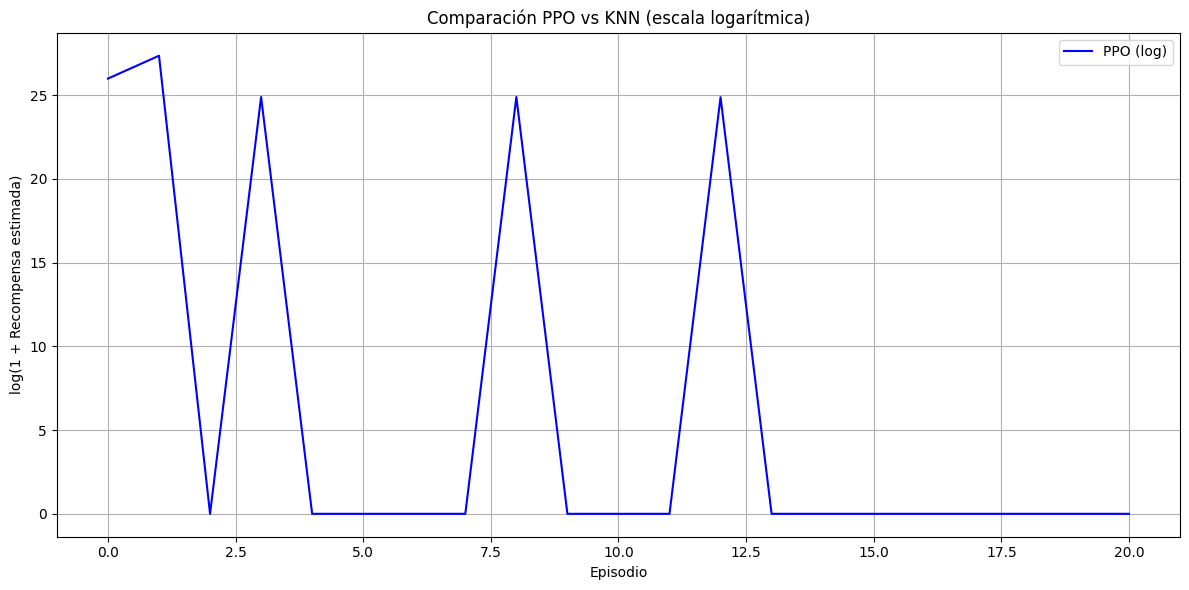

2025-07-01 11:13:56,642 - __main__ - INFO -  Gráfica guardada como './logs\comparacion_ppo_knn_log_20250630_233755.png'


In [151]:
rewards_knn = evaluar_knn_baseline(df_info_clientes_rl, df_resultados_por_cluster, df_simulaciones_info)

graficar_comparacion_con_knn_log(
    agent_keys=AGENTES,
    rewards_knn_df=rewards_knn,
    log_dir=LOG_DIR,
    timestamp=TIMESTAMP
)


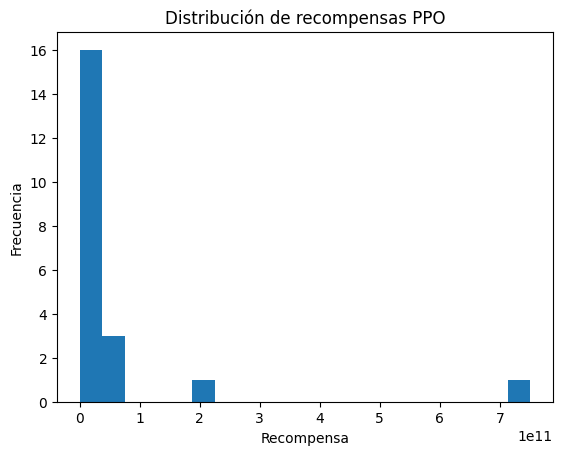

In [141]:
df = pd.read_csv("logs/ppo_monitor.csv", skiprows=1)
plt.hist(df["r"], bins=20)
plt.title("Distribución de recompensas PPO")
plt.xlabel("Recompensa")
plt.ylabel("Frecuencia")
plt.show()
